# Quality Assesment Notebook

This notebook displays basic info and plots. 
It should run on your local computer, provided that you've 
download the \*-exp.fits and \*-exp.h5 files, but you can run
at jupyter.nersc.gov, once you've setup your 
environment (see below).

***WARNING:*** If you open a .h5 file (fit outputs) ***make sure you use the 'r' option***. Otherwise, you might overwrite the file and lose its contents. @TODO: add a protection againts this attack, for now ***please be careful.***

***Reminder***: your modifications will modify your local copy of the notebook, if you want to share those modifications, please do a PR. You might lose them if the notebook is modified and you update picca to the latest master. If you are unsure what this means, make a copy of the file (e.g. to your home) and work with it.

***How to setup the jupyter environment at NERSC***:
(you need to do this only once)

First, create a conda environment dedicated to picca plots:
    
    conda config --add channels intel conda-forge defaults
    conda create -n picca_plots ipykernel fitsio h5py scipy matplotlib healpy
    source activate picca_plots
    cd $HOME/igmhub/picca
    python setup.py install
    python -m ipykernel install --user --name picca_plots --display-name picca_plots
    source deactivate

Point your browser to jupyter.nersc.gov. After you login, you should see a `picca_plots` kernel. Double click on it. Navigate the left menu to open $HOME/igmhub/picca/tutorials/QA_plots.ipynb 

***notes:***

 * The setup.py install step will install picca only in your picca_plots environment and will not conflict with your previous installation, independently of whether you used PYTHONPATH or setup.py install (we need the setup.py install setp in the env because PYTHONPATH is not visible from the jupyter.nersc.gov).


In [2]:
import os
import glob
import copy
import h5py
import fitsio
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from iminuit import Minuit
import scipy as sp
import scipy.stats
import scipy.constants
from scipy.interpolate import interp1d

from picca import wedgize

#%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
#plt.rc('text',usetex=True)

***INFO:*** you can safely ignore the h5py error message (if any) in the cell above

Set up the different path to the data and to the mocks

In [49]:
### Get mocks
mock = {}
mock['team'] = 'london'
mock['mock_ver'] = 'v7.0/v7.0.0'
mock['quick_ver'] = 'eboss-0.0'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/'+mock['team']+'/'+mock['mock_ver']+'/'
mock['mock_quick'] = mock['mock_base']+'/'+mock['quick_ver']+'/'
#mock['mock_quick'] = '/global/cscratch1/sd/hdumasde/igmhub/picca/Understand_fudge_parameter_error/london/v5.0.0/quick-0.0_noFOG_noGaussError_noTransmission_desisimQSO/'
mock['input_nz_QSO'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Nz_qso_130618_2_colore1_hZs.txt'
mock['input_bias_QSO_evol'] = '$HOME/Run_programs/igmhub/picca/CoLoRe_mocks/v4.0/Bz_qso_G18.txt'

In [50]:
### Get mock products
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/'+mock['mock_ver']+'/'+mock['quick_ver']+'//'#+'/lybforest/'
#mock['picca'] = '/global/cscratch1/sd/hdumasde/igmhub/picca/Understand_fudge_parameter_error/london/v5.0.0/quick-0.0_noFOG_noGaussError_noTransmission_desisimQSO/picca//CIV_forests/'
mock['picca_delta'] = mock['picca']+'/deltas/'
mock['picca_delta_attributes'] = mock['picca']+'/iter.fits.gz'
mock['picca_delta_log'] = mock['picca']+'/input.log'
mock['picca_cf1d'] = mock['picca']+'/cf1d_z_0_10.fits.gz'

In [51]:
### Get data products
data = {}
data['forest'] = 'LYA'
data['QSO_catalog'] = '/global/homes/h/hdumasde/Data/Catalogs/DR14Q_v3_1.fits'
data['Spectra'] = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
#data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16/DR16_rebin3_v5_11_00__redone_allObs/'
data['picca'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis/'
data['picca_delta'] = data['picca']+'/Delta_'+data['forest']+'/Delta/'
data['picca_delta_attributes'] = data['picca']+'/Delta_'+data['forest']+'/Log/delta_attributes.fits.gz'
data['picca_cf1d'] = data['picca']+'/Correlations_cf1d/cf1d_'+data['forest']+'.fits.gz'

# __Catalogs__

In [54]:
# Catalogs
cat_path = {'master':mock['mock_base']+'master.fits',
            #'zcat':mock['mock_quick']+'/zcat.fits',
            #'desiDRQ':mock['mock_quick']+'/zcat_desi_drq.fits',
            'Data(DR14)':data['QSO_catalog'],
            #'random':mock['mock_base']+'/master_randoms.fits.gz',
            }
redshift_key = {'master':'Z_QSO_RSD', 'zcat':'Z', 'desiDRQ':'Z','random':'Z','Data(DR14)':'Z'}

### Redshift distribution of the different catalogs

The following cell calculates the redshift distribution of the 
catalogs

master 3618455 3572555
Data(DR14) 446495 248318


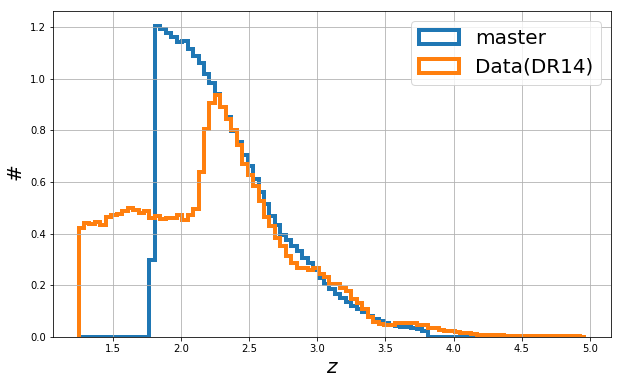

In [56]:
bins = sp.arange(1.25,5.,0.04)
for name,path in cat_path.items():
    h = fitsio.FITS(os.path.expandvars(path))
    z = h[1][redshift_key[name]][:]
    if 'Data' in name:
        z = z[h[1]['MJD'][:]>55000]
    print(name, z.size, z[ (z>1.8)&(z<3.5) ].size)
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()
plt.show()

### Compare final redshift to true redshift

Compare catalogs

257441
257441
[]
257441
[]
257441


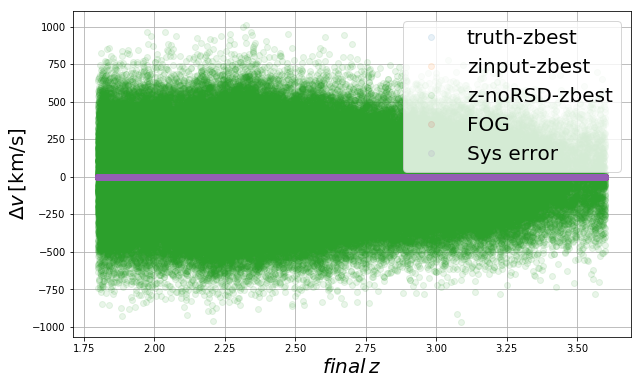

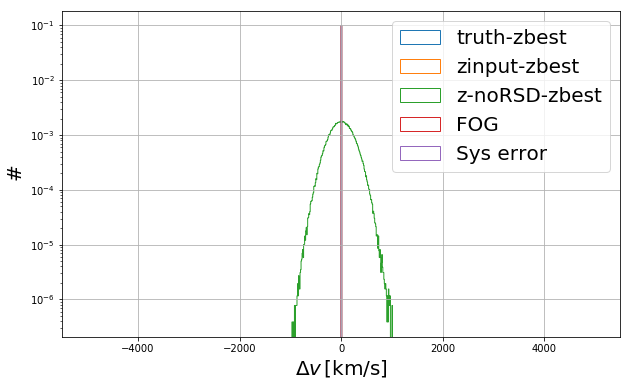

In [138]:
c = sp.constants.speed_of_light/1000. #- km/s

### Final catalog
h = fitsio.FITS(mock['mock_quick']+'/zcat.fits')

final = {}
for k in ['TARGETID','Z']:
    final[k] = h[1][k][:]
h.close()

w = sp.argsort(final['TARGETID'])
for k in final.keys():
    final[k] = final[k][w]
print(final['TARGETID'].size)

### Input catalog
h = fitsio.FITS(mock['mock_quick']+'/zcat_TRUTH.fits')

truth = {}
for k in ['TARGETID','Z','DZ_FOG','DZ_SYS','Z_INPUT','Z_NORSD']:
    truth[k] = h[1][k][:]
if 'DZ_STAT' in h[1].get_colnames():
    truth['DZ_STAT'] = h[1]['DZ_STAT'][:]
h.close()

w = sp.argsort(truth['TARGETID'])
for k in truth.keys():
    truth[k] = truth[k][w]
print(truth['TARGETID'].size)

###
w = sp.in1d(final['TARGETID'],truth['TARGETID'])
print(final['TARGETID'][~w])
for k in final.keys():
    final[k] = final[k][w]
print(final['TARGETID'].size)

w = sp.in1d(truth['TARGETID'],final['TARGETID'])
print(truth['TARGETID'][~w])
for k in truth.keys():
    truth[k] = truth[k][w]
print(truth['TARGETID'].size)

###
plt.errorbar(truth['Z_INPUT'],(truth['Z']-final['Z'])/(1.+final['Z'])*c,fmt='o',label='truth-zbest',alpha=0.1)
plt.errorbar(truth['Z_INPUT'],(truth['Z_INPUT']-final['Z'])/(1.+final['Z'])*c,fmt='o',label='zinput-zbest',alpha=0.1)
plt.errorbar(truth['Z_INPUT'],(truth['Z_NORSD']-final['Z'])/(1.+final['Z'])*c,fmt='o',label='z-noRSD-zbest',alpha=0.1)
plt.errorbar(truth['Z_INPUT'],truth['DZ_FOG']/(1.+final['Z'])*c,fmt='o',label='FOG',alpha=0.1)
plt.errorbar(truth['Z_INPUT'],truth['DZ_SYS']/(1.+final['Z'])*c,fmt='o',label='Sys error',alpha=0.1)
if 'DZ_STAT' in truth.keys():
    plt.errorbar(truth['Z_INPUT'],truth['DZ_STAT']/(1.+final['Z'])*c,fmt='o',label='Stat error',alpha=0.1)
plt.xlabel(r'$final\,z$')
plt.ylabel(r'$\Delta v \, [\mathrm{km/s}]$')
plt.legend()
plt.grid()
plt.show()


###
bins = sp.arange(-5000.,5000.,10)
plt.hist((truth['Z']-final['Z'])/(1.+final['Z'])*c,bins=bins,label='truth-zbest',histtype='step',density=True)
plt.hist((truth['Z_INPUT']-final['Z'])/(1.+final['Z'])*c,bins=bins,label='zinput-zbest',histtype='step',density=True)
plt.hist((truth['Z_NORSD']-final['Z'])/(1.+final['Z'])*c,bins=bins,label='z-noRSD-zbest',histtype='step',density=True)
plt.hist(truth['DZ_FOG']/(1.+final['Z'])*c,bins=bins,label='FOG',histtype='step',density=True)
plt.hist(truth['DZ_SYS']/(1.+final['Z'])*c,bins=bins,label='Sys error',histtype='step',density=True)
if 'DZ_STAT' in truth.keys():
    plt.hist(truth['DZ_STAT']/(1.+final['Z'])*c,bins=bins,label='Stat error',histtype='step',density=True)
plt.xlabel(r'$\Delta v \, [\mathrm{km/s}]$')
plt.ylabel(r'$\#$')
plt.yscale('log')
#plt.xlim([-1000.,1000.])
plt.legend()
plt.grid()
plt.show()

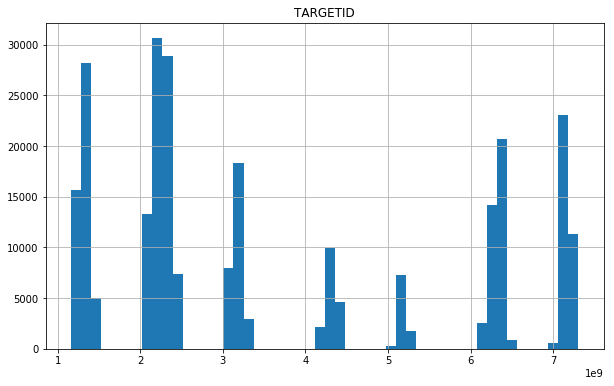

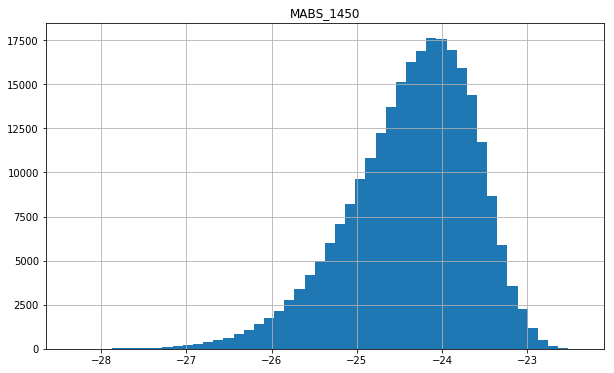

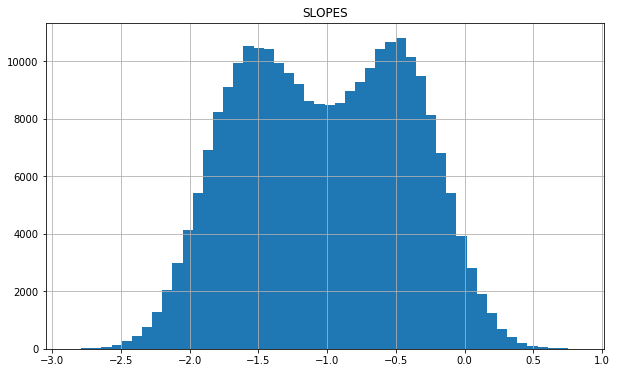

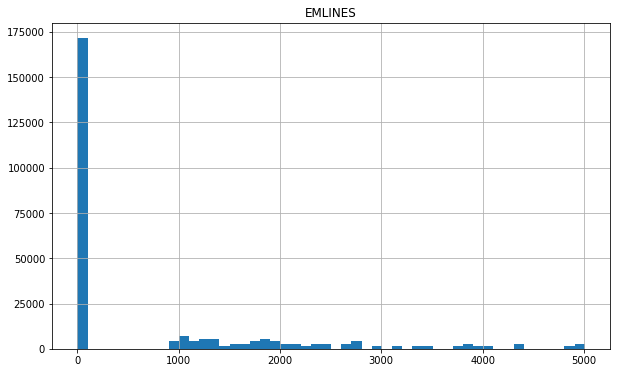

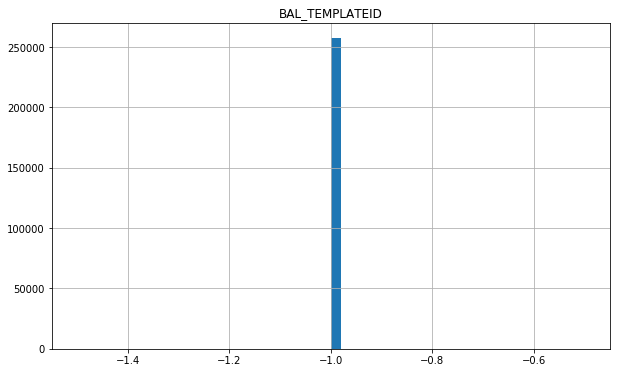

In [139]:
### Input catalog
h = fitsio.FITS(mock['mock_quick']+'/zcat_QSO_META.fits')

cat = {}
for k in ['TARGETID','MABS_1450','SLOPES','EMLINES','BAL_TEMPLATEID']:
    cat[k] = h[1][k][:]
h.close()

for k,v in cat.items():
    plt.hist(v,bins=50)
    plt.title(k)
    plt.grid()
    plt.show()

### Density of objects on the sky

Convert healpix pixel index into ra, dec

In [140]:
def pix2ang_deg(nside,pix,nest=True):
    pix_rad_dec,pix_rad_ra = healpy.pix2ang(nside,pix,nest=nest)
    pix_ra = pix_rad_ra * 180 / sp.pi
    pix_dec = (sp.pi/2.-pix_rad_dec)*180./sp.pi
    return pix_ra, pix_dec

In [141]:
# Catalogs
cat_path2 = {'mocks':mock['mock_quick']+'/zcat_desi_drq.fits',
            'Data(DR14)':data['QSO_catalog'],
            }
redshift_key2 = {'master':'Z_QSO_RSD', 'zcat':'Z', 'mocks':'Z','random':'Z','Data(DR14)':'Z'}

mocks 257441
Data(DR14) 257529


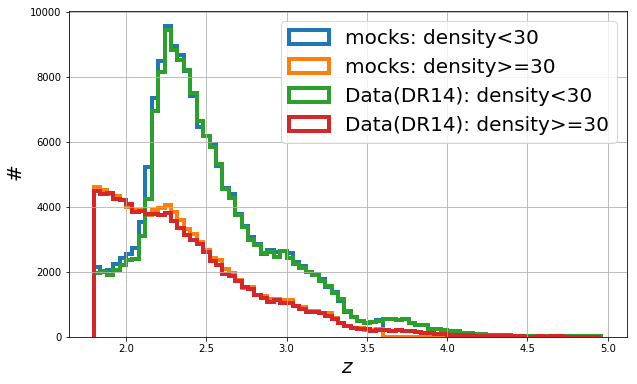

In [142]:
nside = 16
bins = sp.arange(1.8,5.,0.04)
for name,path in cat_path2.items():
    if name=='master': continue
    h = fitsio.FITS(os.path.expandvars(path))
    z = h[1][redshift_key2[name]][:]
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    if 'Data' in name:
        w = h[1]['MJD'][:]>55000
        w &= z>1.8
        z = z[w]
        ra = ra[w]
        dec = dec[w]
    h.close()
    print(name, z.size)

    phi = ra*sp.pi/180.
    th = sp.pi/2.-dec*sp.pi/180.
    pix = healpy.ang2pix(16,th,phi,nest=True)
    unique_pix = sp.unique(pix)
    ra_pix,dec_pix = pix2ang_deg(nside,unique_pix)
    bincounts_pix = sp.bincount(pix)
    area_pix = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
    density = bincounts_pix[unique_pix]/area_pix

    w = sp.in1d(pix,unique_pix[density<30.])
    plt.hist(z[w],bins=bins,histtype='step',label=name+': density<30',density=False,linewidth=4)
    w = sp.in1d(pix,unique_pix[density>=30.])
    plt.hist(z[w],bins=bins,histtype='step',label=name+': density>=30',density=False,linewidth=4)
    
plt.xlabel(r'$z$')
plt.ylabel(r'$\mathrm{\#}$')
plt.legend()
plt.grid()
plt.show()

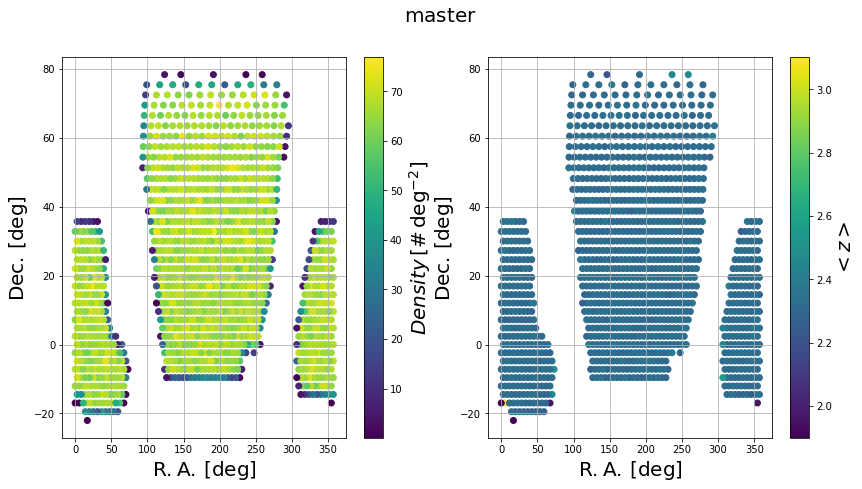

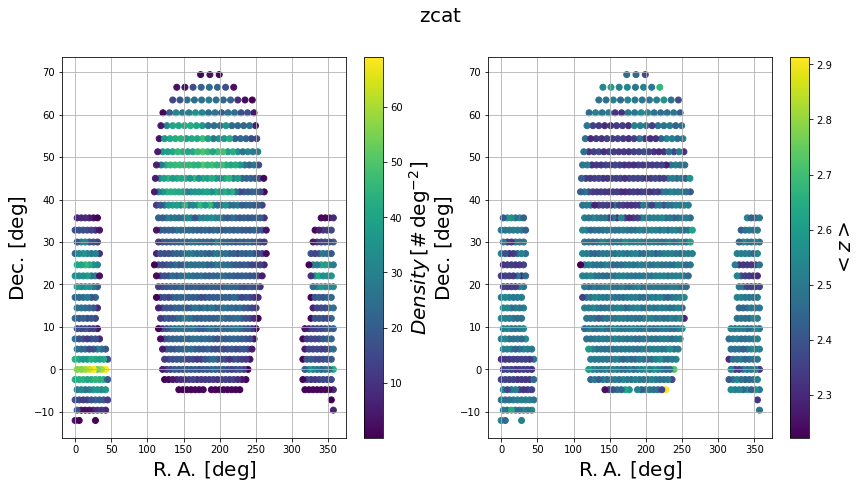

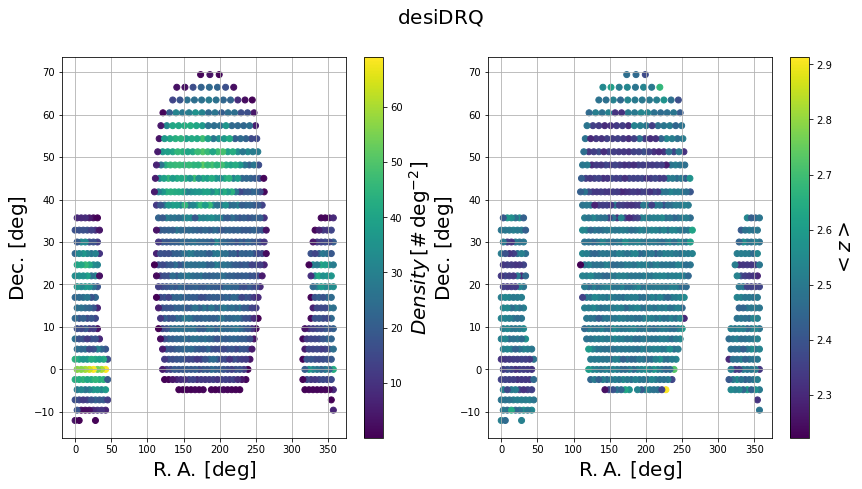

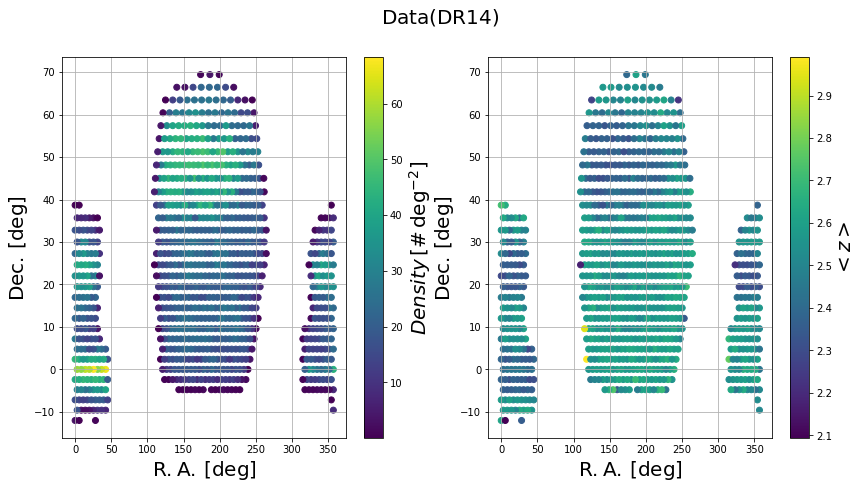

In [143]:
nside = 16
sp.random.seed(42)
nbQSO = 1000000
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    z = h[1][redshift_key[name]][:]

    w = z>1.8
    if 'Data' in name:
        w &= h[1]['MJD'][:]>55000
    ra = ra[w]
    dec = dec[w]
    z = z[w]

    h.close()
    
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,nbQSO),replace=False)
    ra = ra[w]
    dec = dec[w]
    z = z[w]

    phi = ra*sp.pi/180.
    th = sp.pi/2.-dec*sp.pi/180.
    pix = healpy.ang2pix(nside,th,phi,nest=True)
    unique_pix = sp.unique(pix)
    ra_pix,dec_pix = pix2ang_deg(nside,unique_pix)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)

    bincounts_pix = sp.bincount(pix)
    area_pix = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
    density = bincounts_pix[unique_pix]/area_pix
    
    plot1 = ax1.scatter(ra_pix,dec_pix,c=density)
    cbar1 = plt.colorbar(plot1, ax=ax1)
    cbar1.set_label(r'$Density \, [\mathrm{\# \, deg^{-2}}]$',size=20)
    cbar1.update_ticks()
    ax1.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax1.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax1.grid()

    bincounts_pix = sp.bincount(pix)
    bincounts_z = sp.bincount(pix,weights=z)
    z_pix = bincounts_z[unique_pix]/bincounts_pix[unique_pix]

    plot2 = ax2.scatter(ra_pix,dec_pix,c=z_pix)
    cbar2 = plt.colorbar(plot2,ax=ax2)
    cbar2.set_label(r'$<z>$',size=20)
    cbar2.update_ticks()
    ax2.set_xlabel(r'$\mathrm{R.A. \, [deg]}$')
    ax2.set_ylabel(r'$\mathrm{Dec. \, [deg]}$')
    ax2.grid()

    plt.subplots_adjust(wspace=0.2)
    plt.show()

### Magnitude distribution

In [144]:
color = {'u':'violet', 'g':'red', 'r':'green', 'i':'orange', 'z':'blue',
        'g: decam':'red', 'r: decam':'green', 'z: decam':'blue'}

In [145]:
toPlot = {}
toPlot['Mocks'] = {}
toPlot['Mocks']['NAME'] = {0:'g: decam', 1:'r: decam', 2:'z: decam'}#, 3:'wise1', 4:'wise2'}
h = fitsio.FITS(cat_path['zcat'])
flx = sp.zeros( (h['ZCATALOG']['FLUX_G'][:].size,3) )
flx[:,0] = h['ZCATALOG']['FLUX_G'][:]
flx[:,1] = h['ZCATALOG']['FLUX_R'][:]
flx[:,2] = h['ZCATALOG']['FLUX_Z'][:]
#flx[:,3] = h['ZCATALOG']['FLUX_W1'][:]
#flx[:,4] = h['ZCATALOG']['FLUX_W2'][:]
toPlot['Mocks']['FLUX'] = flx.copy()
toPlot['Mocks']['Z'] = h['ZCATALOG']['Z'][:]
toPlot['Mocks']['RA'] = h['ZCATALOG']['RA'][:]
toPlot['Mocks']['DEC'] = h['ZCATALOG']['DEC'][:]
h.close()

In [146]:
toPlot['Data'] = {}
toPlot['Data']['NAME'] = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z'}
h = fitsio.FITS(data['QSO_catalog'])
toPlot['Data']['FLUX'] = h[1]['PSFFLUX'][:]
toPlot['Data']['Z'] = h[1]['Z'][:]
toPlot['Data']['RA'] = h[1]['RA'][:]
toPlot['Data']['DEC'] = h[1]['DEC'][:]
h.close()

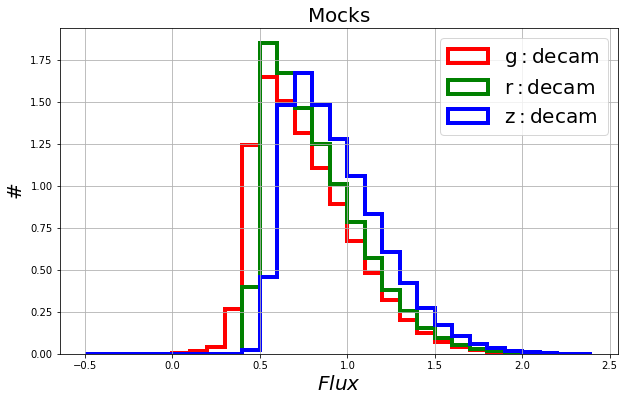

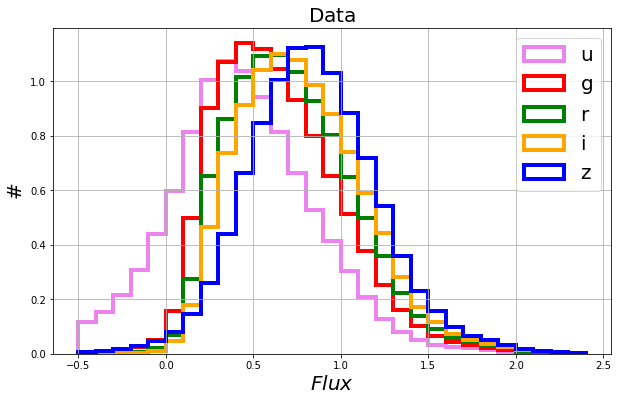

In [147]:
for name,vals in toPlot.items():
    flx = vals['FLUX']
    for i in range(vals['FLUX'].shape[1]):
        w = flx[:,i]>0.
        bins = sp.arange(sp.log10(flx[:,i][w].min()), sp.log10(flx[:,i][w].max()), 0.1)
        bins = sp.arange(-0.5,2.5,0.1)
        #bins = sp.arange(0.,100.,1.)
        plt.hist(sp.log10(flx[:,i][w]),linewidth=4,histtype='step',bins=bins,
                 label=r'$\mathrm{'+vals['NAME'][i]+'}$',color=color[vals['NAME'][i]],density=True)
    plt.xlabel(r'$Flux$')
    plt.ylabel(r'$\#$')
    plt.title(r'$\mathrm{'+name+'}$',fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

#### The following function allows to get the profile

In [148]:
def Get_TProfile(ar1, ar2, nbBin1, we2=None):

    if we2 is None:
        we2 = sp.ones_like(ar1)
    number, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1))
    weight, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2)
    mean,   axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*ar2)
    err,    axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*(ar2**2.))

    ### find the axis X
    axisX = sp.array([ axisX[i]+(axisX[i+1]-axisX[i])/2. for i in range(0,axisX.size-1) ])
    
    ### Get only not empty bins
    bool_number = (number[:,0]>1)
    
    axisX  = axisX[bool_number]
    number = number[:,0][bool_number]
    weight = weight[:,0][bool_number]
    mean   = mean[:,0][bool_number]
    err    = err[:,0][bool_number]

    mean  = mean/weight
    err   = sp.sqrt((err/weight-mean**2.)/number)

    return axisX, mean, err, number

### Magnitude vs. redshift

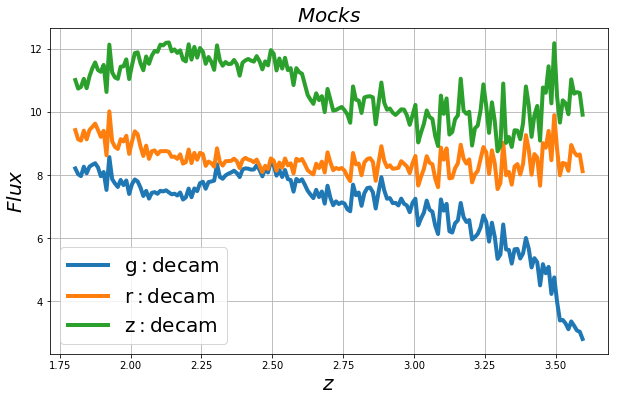

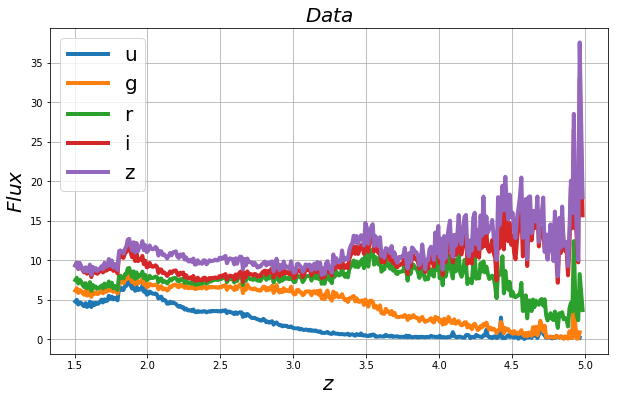

In [149]:
bins = sp.arange(1.5, 5., 0.01)
for name,vals in toPlot.items():
    flx = vals['FLUX']
    for i in range(flx.shape[1]):
        w = flx[:,i]>0.
        axisX, mean, err, number = Get_TProfile(vals['Z'][w],flx[:,i][w], bins)
        plt.plot(axisX, mean,linewidth=4,label=r'$\mathrm{'+vals['NAME'][i]+'}$')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$Flux$')
    plt.title(r'$'+name+'$',fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

### Magnitude on the sky

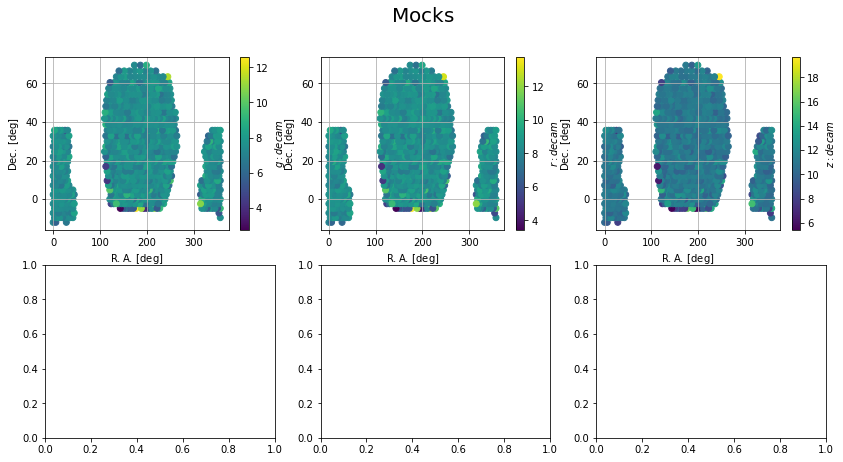

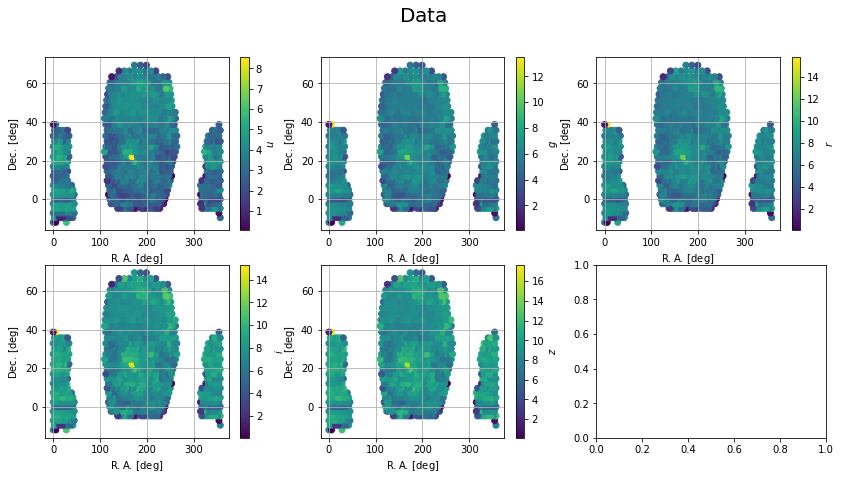

In [150]:
nside = 16

for name,vals in toPlot.items():
    flx = vals['FLUX']
    ra = vals['RA']
    dec = vals['DEC']

    phi = ra*sp.pi/180.
    th = sp.pi/2.-dec*sp.pi/180.
    pix = healpy.ang2pix(nside,th,phi,nest=True)
    unique_pix = sp.unique(pix)
    ra_pix,dec_pix = pix2ang_deg(nside,unique_pix)
    bincounts_pix = sp.bincount(pix)

    f, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
    plt.suptitle(r'$\mathrm{'+name+'}$',fontsize=20)
    plot = []
    cbar = []
    
    for i in range(flx.shape[1]):
        w = flx[:,i]>0.

        bincounts_flx = sp.bincount(pix[w],weights=flx[:,i][w])
        flx_pix = bincounts_flx[unique_pix]/bincounts_pix[unique_pix]
        w = flx_pix>0.
    
        plot += [axs[i//3,i%3].scatter(ra_pix[w],dec_pix[w],c=flx_pix[w])]
        cbar += [plt.colorbar(plot[-1],ax=axs[i//3,i%3])]
        cbar[-1].set_label(r'$'+vals['NAME'][i]+'$',size=10)
        cbar[-1].update_ticks()
        axs[i//3,i%3].set_xlabel(r'$\mathrm{R.A. \, [deg]}$',fontsize=10)
        axs[i//3,i%3].set_ylabel(r'$\mathrm{Dec. \, [deg]}$',fontsize=10)
        axs[i//3,i%3].grid()

    plt.show()

# __Lya Transmission__

In [57]:
### Get all transmission files
fs = sp.sort(glob.glob(mock['mock_base']+'/*/*/transmission-*-*.fits*'))
fs = fs[:10]

In [58]:
lLYA = 1215.67

absorption = {}

absorption['LYA'] = {}
absorption['LYA']['lminforest'] = 1025.72
absorption['LYA']['lmaxforest'] = 1215.67

absorption['LYB'] = {}
absorption['LYB']['lminforest'] = 972.537
absorption['LYB']['lmaxforest'] = 1025.72

absorption['MORE'] = {}
absorption['MORE']['lminforest'] = 100.
absorption['MORE']['lmaxforest'] = 972.537

In [59]:
### Along the observed wavelength 
lObs_min = 3000.
lObs_max = 8000.
for k in absorption.keys():
    absorption[k]['lObs_stack'] = sp.arange(lObs_min,lObs_max,1.)
    absorption[k]['z_stack'] = absorption[k]['lObs_stack']/lLYA-1.
    absorption[k]['T_stack'] = sp.zeros(absorption[k]['lObs_stack'].size)
    absorption[k]['TVar_stack'] = sp.zeros(absorption[k]['lObs_stack'].size)
    absorption[k]['n_stack'] = sp.zeros(absorption[k]['lObs_stack'].size)

    absorption[k]['T_stack_delta'] = sp.zeros(absorption[k]['lObs_stack'].size)
    absorption[k]['TVar_stack_delta'] = sp.zeros(absorption[k]['lObs_stack'].size)
    absorption[k]['n_stack_delta'] = sp.zeros(absorption[k]['lObs_stack'].size)

In [60]:
### Along the rest-frame wavelength
lRF_min = 100.
lRF_max = 4000.
for k in absorption.keys():
    absorption[k]['lRF_stack'] = sp.arange(lRF_min,lRF_max,1.)
    absorption[k]['T_lRF_stack'] = sp.zeros(absorption[k]['lRF_stack'].size)
    absorption[k]['TVar_lRF_stack'] = sp.zeros(absorption[k]['lRF_stack'].size)
    absorption[k]['n_lRF_stack'] = sp.zeros(absorption[k]['lRF_stack'].size)
    absorption[k]['T_lRF_stack_delta'] = sp.zeros(absorption[k]['lRF_stack'].size)
    absorption[k]['TVar_lRF_stack_delta'] = sp.zeros(absorption[k]['lRF_stack'].size)
    absorption[k]['n_lRF_stack_delta'] = sp.zeros(absorption[k]['lRF_stack'].size)

In [61]:
### Get the transmission
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    _lObs = h['WAVELENGTH'].read()
    _trans = h['TRANSMISSION'].read()
    _lRF = _lObs/(1.+z[:,None])
    _lObs = _lObs*sp.ones(z.size)[:,None]
    
    
    for k in absorption.keys():
        w = (_lRF>absorption[k]['lminforest']) & (_lRF<absorption[k]['lmaxforest'])
        lObs = _lObs[w]
        lRF = _lRF[w]
        trans = _trans[w]

        bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*absorption[k]['lObs_stack'].size ).astype(int)
        absorption[k]['T_stack'] += sp.bincount(bins,weights=trans,minlength=absorption[k]['lObs_stack'].size)
        absorption[k]['TVar_stack'] += sp.bincount(bins,weights=trans**2,minlength=absorption[k]['lObs_stack'].size)
        absorption[k]['n_stack'] += sp.bincount(bins,minlength=absorption[k]['lObs_stack'].size)

        bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*absorption[k]['lRF_stack'].size ).astype(int)
        absorption[k]['T_lRF_stack'] += sp.bincount(bins,weights=trans,minlength=absorption[k]['lRF_stack'].size)
        absorption[k]['TVar_lRF_stack'] += sp.bincount(bins,weights=trans**2,minlength=absorption[k]['lRF_stack'].size)
        absorption[k]['n_lRF_stack'] += sp.bincount(bins,minlength=absorption[k]['lRF_stack'].size)

In [62]:
for k in absorption.keys():
    ### Normalize the vectors (obseved wavelength)
    w = absorption[k]['n_stack']>0.
    absorption[k]['T_stack'][w] /= absorption[k]['n_stack'][w]
    absorption[k]['TVar_stack'][w] /= absorption[k]['n_stack'][w]
    absorption[k]['TVar_stack'] -= absorption[k]['T_stack']**2
    absorption[k]['trans_vs_lObs'] = interp1d(absorption[k]['lObs_stack'][w],absorption[k]['T_stack'][w],fill_value='extrapolate',kind='nearest')

    ### Normalize the vectors (rest-frame wavelength)
    w = absorption[k]['n_lRF_stack']>0.
    absorption[k]['T_lRF_stack'][w] /= absorption[k]['n_lRF_stack'][w]
    absorption[k]['TVar_lRF_stack'][w] /= absorption[k]['n_lRF_stack'][w]
    absorption[k]['TVar_lRF_stack'] -= absorption[k]['T_lRF_stack']**2

In [63]:
### Get the delta
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    _lObs = h['WAVELENGTH'].read()
    _trans = h['TRANSMISSION'].read()
    _lRF = _lObs/(1.+z[:,None])
    _lObs = _lObs*sp.ones(z.size)[:,None]
    h.close()

    for k in absorption.keys():
        w = (_lRF>absorption[k]['lminforest']) & (_lRF<absorption[k]['lmaxforest'])
        lObs = _lObs[w]
        lRF = _lRF[w]
        trans = _trans[w]/absorption[k]['trans_vs_lObs'](lObs)-1.
        
        bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*absorption[k]['lObs_stack'].size ).astype(int)
        absorption[k]['T_stack_delta'] += sp.bincount(bins,weights=trans,minlength=absorption[k]['lObs_stack'].size)
        absorption[k]['TVar_stack_delta'] += sp.bincount(bins,weights=trans**2,minlength=absorption[k]['lObs_stack'].size)
        absorption[k]['n_stack_delta'] += sp.bincount(bins,minlength=absorption[k]['lObs_stack'].size)

        bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*absorption[k]['lRF_stack'].size ).astype(int)
        absorption[k]['T_lRF_stack_delta'] += sp.bincount(bins,weights=trans,minlength=absorption[k]['lRF_stack'].size)
        absorption[k]['TVar_lRF_stack_delta'] += sp.bincount(bins,weights=trans**2,minlength=absorption[k]['lRF_stack'].size)
        absorption[k]['n_lRF_stack_delta'] += sp.bincount(bins,minlength=absorption[k]['lRF_stack'].size)

In [64]:
for k in absorption.keys():
    ### Normalize the vectors (obseved wavelength)
    w = absorption[k]['n_stack_delta']>0.
    absorption[k]['T_stack_delta'][w] /= absorption[k]['n_stack_delta'][w]
    absorption[k]['TVar_stack_delta'][w] /= absorption[k]['n_stack_delta'][w]
    absorption[k]['TVar_stack_delta'] -= absorption[k]['T_stack_delta']**2

    ### Normalize the vectors (rest-frame wavelength)
    w = absorption[k]['n_lRF_stack_delta']>0.
    absorption[k]['T_lRF_stack_delta'][w] /= absorption[k]['n_lRF_stack_delta'][w]
    absorption[k]['TVar_lRF_stack_delta'][w] /= absorption[k]['n_lRF_stack_delta'][w]
    absorption[k]['TVar_lRF_stack_delta'] -= absorption[k]['T_lRF_stack_delta']**2

In [65]:
### from measurement on data
### The input mean flux that we were trying to match corresponds
### to F(z=2.25)=0.8, and a slope in optical depth of (1+z)^3.2.
#A = -sp.log(0.8)/(1.+2.25)**3.2
#B = 3.2

# V. Kamble in prep
# tau_o = 0.0056
# gamma = 3.17
A = 0.0056
B = 3.17
print(' optical depth = ', A, B)
T_measure = sp.exp(-A*(1.+absorption['LYA']['z_stack'])**B)
DVar_measure = 0.0016*(1.+absorption['LYA']['z_stack'])**(2.*2.9-2.)
TVar_measure = DVar_measure*T_measure**2

# T.-S. Kim et al. 2007
# https://arxiv.org/abs/0711.1862
#
A2 = 0.0054
B2 = 2.96
print(' optical depth = ', A2, B2)
T_measure2 = sp.exp(-A2*(1.+absorption['LYA']['z_stack'])**B2)
DVar_measure2 = 0.0016*(1.+absorption['LYA']['z_stack'])**(2.*2.9-2.)
TVar_measure2 = DVar_measure2*T_measure2**2

 optical depth =  0.0056 3.17
 optical depth =  0.0054 2.96


### Transmission vs. redshift

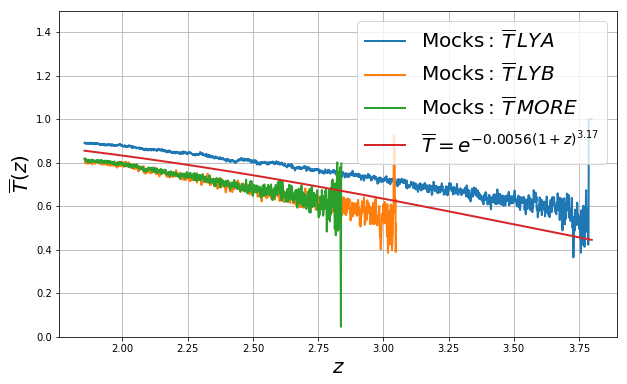

In [66]:
for k in absorption.keys():
    w = absorption[k]['n_stack']>0.
    plt.plot(absorption[k]['z_stack'][w],absorption[k]['T_stack'][w],linewidth=2,label=r'$\mathrm{Mocks:} \, \overline{T} \, '+format(k)+'$')
    #w = absorption[k]['n_stack_delta']>0.
    #plt.plot(1.+absorption[k]['z_stack'][w],absorption[k]['T_stack_delta'][w],linewidth=2,label=r'$\mathrm{Mocks: \, \delta}$')

for k in ['LYA']:
    w = absorption[k]['n_stack']>0.
    plt.plot(absorption[k]['z_stack'][w],T_measure[w],linewidth=2,label=r'$\overline{T} = e^{-0.0056(1+z)^{3.17}}$')
    #plt.plot(absorption['LYA']['z_stack'][w],absorption['LYA']['T_stack'][w]/T_measure[w],linewidth=2,label=r'$Mock / model$')

plt.xlabel(r'$z$')
plt.ylabel(r'$\overline{T}(z)$')
plt.legend()
plt.grid()
_ = plt.ylim(0.,1.5)
plt.show()

### Optical depth vs. redshift

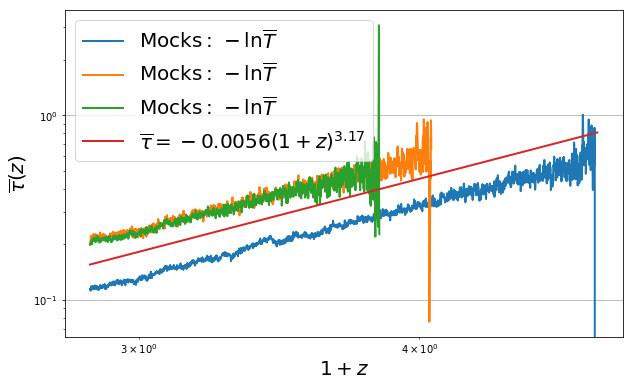

In [67]:
for k in absorption.keys():
    w = absorption[k]['n_stack']>0.
    plt.plot(1.+absorption[k]['z_stack'][w],-sp.log(absorption[k]['T_stack'][w]),linewidth=2,label=r'$\mathrm{Mocks:} \, -\ln{\overline{T}}$')
    w = absorption[k]['n_stack_delta']>0.
    #plt.plot(1.+absorption[k]['z_stack'][w],absorption[k]['T_stack_delta'][w],linewidth=2,label=r'$\mathrm{Mocks: \, \delta}$')

for k in ['LYA']:
    w = absorption[k]['n_stack']>0.
    plt.plot(1.+absorption[k]['z_stack'][w],A*(1.+absorption[k]['z_stack'][w])**B,linewidth=2,label=r'$\overline{\tau} = -0.0056(1+z)^{3.17}$')
    #plt.plot(1.+absorption[k]['z_stack'][w],-sp.log(absorption[k]['T_stack'][w])/(A*(1.+absorption[k]['z_stack'][w])**B),linewidth=2,label=r'$Mock / model$')

plt.xlabel(r'$1+z$')
plt.ylabel(r'$\overline{\tau}(z)$')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

### Variance of the transmission vs. of redshift

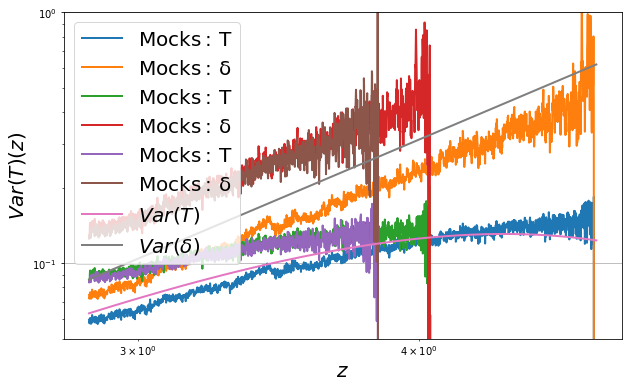

In [68]:
for k in absorption.keys():
    w = absorption[k]['n_stack']>0.
    plt.plot(1.+absorption[k]['z_stack'][w],absorption[k]['TVar_stack'][w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
    w = absorption[k]['n_stack_delta']>0.
    plt.plot(1.+absorption[k]['z_stack'][w],absorption[k]['TVar_stack_delta'][w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')

for k in ['LYA']:
    w = absorption[k]['n_stack']>0.
    plt.plot(1.+absorption[k]['z_stack'][w],TVar_measure[w],linewidth=2,label=r'$Var(T)$')# = 0.0018 (1+z)^{2*2.9-2} * <T(z)>^{2}$')
    w = absorption[k]['n_stack_delta']>0.
    plt.plot(1.+absorption[k]['z_stack'][w],DVar_measure[w],linewidth=2,label=r'$Var(\delta)$')# = 0.0018 (1+z)^{2*2.9-2}$')    

plt.xlabel(r'$z$')
plt.ylabel(r'$Var(T)(z)$')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
_=plt.ylim(0.05,1)
plt.show()

### Transmission vs. rest-frame wavelength

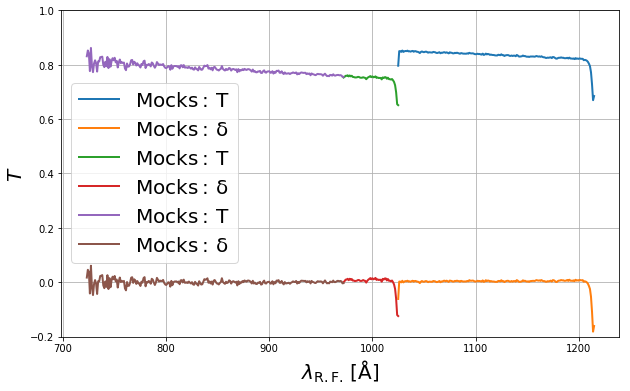

In [69]:
for k in absorption.keys():
    w = absorption[k]['n_lRF_stack']>0.
    plt.plot(absorption[k]['lRF_stack'][w],absorption[k]['T_lRF_stack'][w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
    w = absorption[k]['n_lRF_stack_delta']>0.
    plt.plot(absorption[k]['lRF_stack'][w],absorption[k]['T_lRF_stack_delta'][w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')

plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$T$')
plt.legend()
plt.ylim(-0.2,1)
plt.grid()
plt.show()

### Variance of the transmission vs. rest-frame wavelength

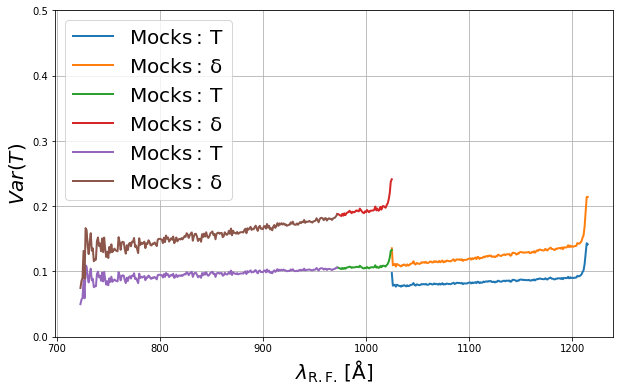

In [70]:
for k in absorption.keys():
    w = absorption[k]['n_lRF_stack']>0.
    plt.plot(absorption[k]['lRF_stack'][w],absorption[k]['TVar_lRF_stack'][w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
    w = absorption[k]['n_lRF_stack_delta']>0.
    plt.plot(absorption[k]['lRF_stack'][w],absorption[k]['TVar_lRF_stack_delta'][w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')

plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$Var(T)$')
plt.legend()
plt.ylim([0.,0.5])
plt.grid()
plt.show()

# __Example spectrum__

In [228]:
### Get the different path to spectrum
#trans_path = mock['mock_base']+'/0/0/transmission-16-0.fits'
#spec_path = mock['mock_quick']+'/spectra-16/0/0/spectra-16-0.fits'
#trans_path = mock['mock_base']+'/1/137/transmission-16-137.fits'
#spec_path = mock['mock_quick']+'/spectra-16/1/137/spectra-16-137.fits'
trans_path = mock['mock_base']+'/7/745/transmission-16-745.fits'
spec_path = mock['mock_quick']+'/spectra-16/7/745/spectra-16-745.fits'

In [229]:
### Get delta nside
try:
    h = fitsio.FITS(mock['picca_delta_attributes'])
    nside = h[1].read_header()['NSIDE']
    h.close()
except:
    pass

In [230]:
### Get the spectrum
try:
    h = fitsio.FITS(spec_path)
except:
    h = fitsio.FITS(spec_path+'.gz')
try:
    hra = h['FIBERMAP']['TARGET_RA'][:]
    hde = h['FIBERMAP']['TARGET_DEC'][:]
except ValueError:
    hra = h['FIBERMAP']['RA_TARGET'][:]
    hde = h['FIBERMAP']['DEC_TARGET'][:]
tid = h['FIBERMAP']['TARGETID'][:]
b_ll = sp.log10(h['B_WAVELENGTH'].read())
b_iv = h['B_IVAR'].read()*(h['B_MASK'].read()==0)
b_fl = h['B_FLUX'].read()
w = sp.isnan(b_iv) | sp.isnan(b_fl)
b_iv[w] = 0.
b_fl[w] = 0.
r_ll = sp.log10(h['R_WAVELENGTH'].read())
r_iv = h['R_IVAR'].read()*(h['R_MASK'].read()==0)
r_fl = h['R_FLUX'].read()
w = sp.isnan(r_iv) | sp.isnan(r_fl)
r_iv[w] = 0.
r_fl[w] = 0.
try:
    z_ll = sp.log10(h['Z_WAVELENGTH'].read())
    z_iv = h['Z_IVAR'].read()*(h['Z_MASK'].read()==0)
    z_fl = h['Z_FLUX'].read()
    w = sp.isnan(z_iv) | sp.isnan(z_fl)
    z_iv[w] = 0.
    z_fl[w] = 0.
except:
    print('WARNING: No z spectrograph')
    pass

In [231]:
### Get Transmission
try:
    h = fitsio.FITS(trans_path)
except:
    h = fitsio.FITS(trans_path+'.gz')
z = h['METADATA']['Z'][:]
ra = h['METADATA']['RA'][:]
de = h['METADATA']['DEC'][:]
lObs = h['WAVELENGTH'].read()
trans = h['TRANSMISSION'].read()
zdla = h['DLA']['Z_DLA_RSD'][:]
mockiddla = h['DLA']['MOCKID'][:]
h.close()
lRF = lObs/(1.+z[:,None])
lObs = lObs*sp.ones(z.size)[:,None]

3.9274845
0.999999999992724 1.000000000007276


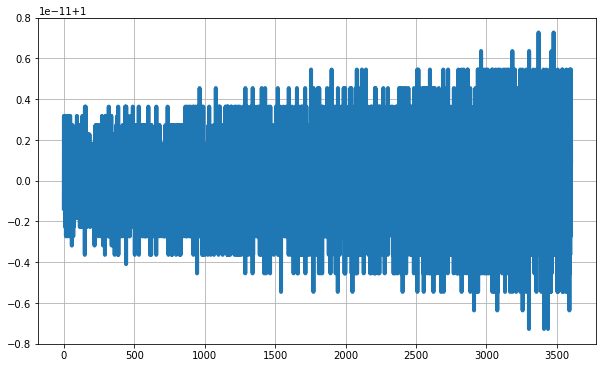

6.086903650492914e-05 0.00012289382744334887


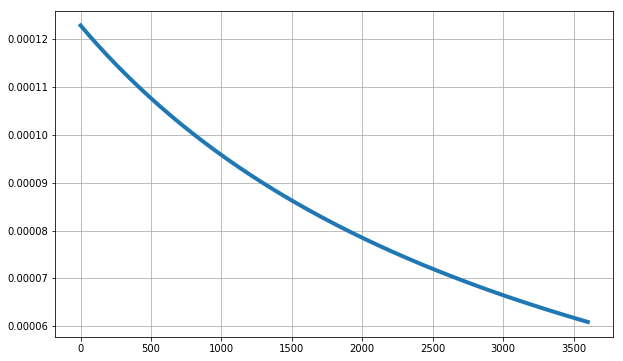

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in power


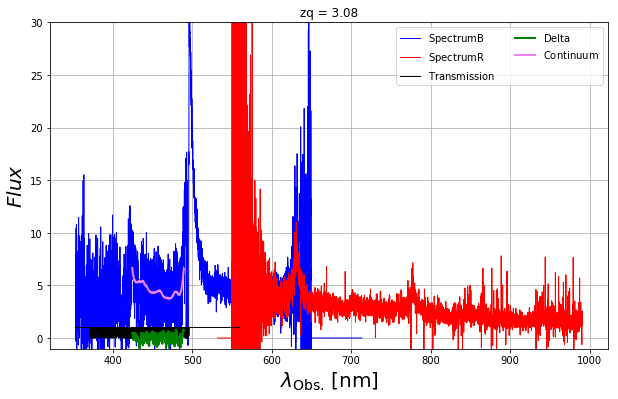

3.6920073
0.999999999992724 1.000000000007276


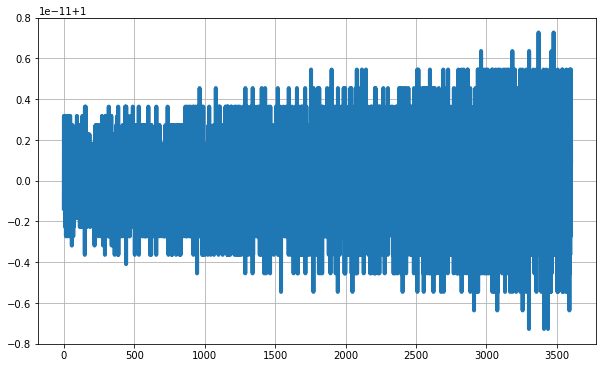

6.086903650492914e-05 0.00012289382744334887


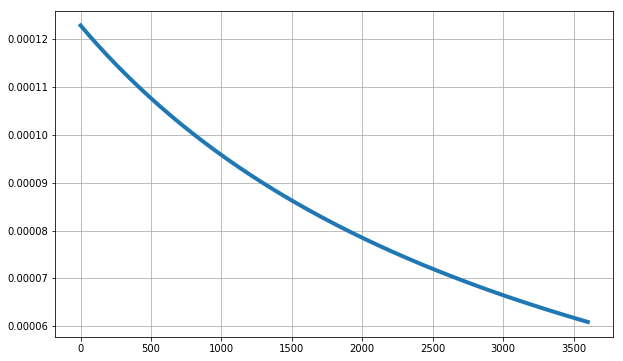

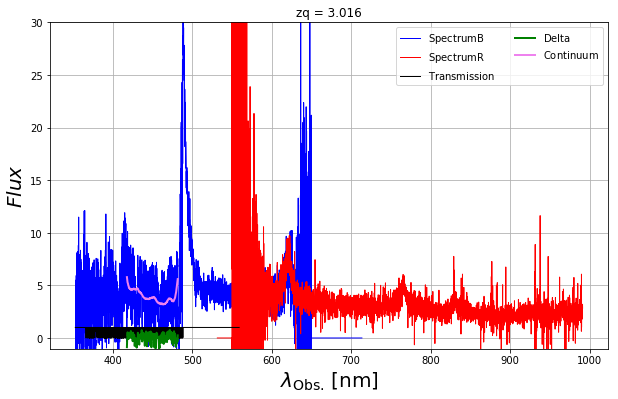

IndexError: index 294 is out of bounds for axis 0 with size 294

In [237]:
### Plot the first n spectra
for idx in range(10000):
    ra_idx = hra[idx]
    de_idx = hde[idx]
    z_idx = z[ra==hra[idx]][0]
    if z_idx<3.0: continue
    tid_idx = tid[idx]
    
    snr = (b_fl[idx,:]*sp.sqrt(b_iv[idx,:])).mean()
    if snr<3.:
        continue
    print(snr)
    
    print( (10**b_ll[1:]-10**b_ll[:-1]).min(),(10**b_ll[1:]-10**b_ll[:-1]).max()  )
    plt.plot(10**b_ll[1:]-10**b_ll[:-1])
    plt.grid()
    plt.show()
    print( (b_ll[1:]-b_ll[:-1]).min(),(b_ll[1:]-b_ll[:-1]).max()  )
    plt.plot(b_ll[1:]-b_ll[:-1])
    plt.grid()
    plt.show()

    nidx = sp.arange(ra.size)[ra==ra_idx][0]
    plt.plot(10**b_ll/10.,b_fl[idx,:],color='blue',label=r'$\mathrm{Spectrum B}$',linewidth=1)
    plt.plot(10**r_ll/10.,r_fl[idx,:],color='red',label=r'$\mathrm{Spectrum R}$',linewidth=1)
    try:
        plt.plot(10**z_ll/10.,z_fl[idx,:],color='orange',label=r'$\mathrm{Spectrum Z}$',linewidth=1)
    except:
        pass
    plt.plot(lObs[nidx,:]/10.,trans[nidx,:],color='black',label=r'$\mathrm{Transmission}$',linewidth=1)
    if True:
        try:
            delt_pix = healpy.ang2pix(nside, sp.pi/2.-de_idx*sp.pi/180., ra_idx*sp.pi/180.)
            delta = fitsio.FITS(mock['picca_delta']+'/delta-'+str(delt_pix)+'.fits.gz')
            deltaa = delta[str(tid_idx)]
            plt.plot(10**deltaa['LOGLAM'][:]/10.,deltaa['DELTA'][:],color='green',label=r'$\mathrm{Delta}$',linewidth=2)
            plt.plot(10**deltaa['LOGLAM'][:]/10.,deltaa['CONT'][:],color='violet',label=r'$\mathrm{Continuum}$',linewidth=2)
        except:
            print('not found')
            pass
    plt.title('zq = {}'.format(1.*int(z[ra==hra[idx]][0]*1000.)/1000.))
    plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{nm}]$')
    plt.ylabel(r'$Flux$')
    plt.legend(ncol=2,fontsize=10)
    #plt.xlim([350.,500.])
    plt.ylim([-1.,30.])
    plt.grid()
    plt.show()
    #break

# __Distribution of flux, ivar and SNR__

In [173]:
toPlot = {}

In [174]:
### Mocks
toPlot['Mocks'] = {'WAVE':None, 'FLUX':None, 'IVAR':None}
fs = sp.sort(glob.glob(mock['mock_quick']+'/spectra-16/*/*/spectra-16-*.fits'))
fs = fs[:10]
for f in fs:
    h = fitsio.FITS(f)
    nbQSO = h['B_IVAR'].read().shape[0]
    
    b_ll = h['B_WAVELENGTH'].read()
    b_ll = b_ll*sp.ones(nbQSO)[:,None]
    b_iv = h['B_IVAR'].read()*(h['B_MASK'].read()==0)
    b_fl = h['B_FLUX'].read()
    
    r_ll = h['R_WAVELENGTH'].read()
    r_ll = r_ll*sp.ones(nbQSO)[:,None]
    r_iv = h['R_IVAR'].read()*(h['R_MASK'].read()==0)
    r_fl = h['R_FLUX'].read()
    
    try:
        z_ll = h['Z_WAVELENGTH'].read()
        z_ll = z_ll*sp.ones(nbQSO)[:,None]
        z_iv = h['Z_IVAR'].read()*(h['Z_MASK'].read()==0)
        z_fl = h['Z_FLUX'].read()
    except:
        pass

    wave = sp.append(b_ll,r_ll)
    flux = sp.append(b_fl,r_fl)
    ivar = sp.append(b_iv,r_iv)
    try:
        wave = sp.append(wave,z_ll)
        flux = sp.append(flux,z_fl)
        ivar = sp.append(ivar,z_iv)
    except:
        pass

    w = ivar>0.
        
    if toPlot['Mocks']['WAVE'] is None:
        toPlot['Mocks']['WAVE'] = wave[w].copy().flatten()
        toPlot['Mocks']['FLUX'] = flux[w].copy().flatten()
        toPlot['Mocks']['IVAR'] = ivar[w].copy().flatten()
    else:
        toPlot['Mocks']['WAVE'] = sp.append(toPlot['Mocks']['WAVE'],wave[w])
        toPlot['Mocks']['FLUX'] = sp.append(toPlot['Mocks']['FLUX'],flux[w])
        toPlot['Mocks']['IVAR'] = sp.append(toPlot['Mocks']['IVAR'],ivar[w])

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


In [175]:
### Data
toPlot['Data'] = {'WAVE':None, 'FLUX':None, 'IVAR':None}
h = fitsio.FITS(data['QSO_catalog'])
w = (h[1]['Z'][:]>1.8) & (sp.arange(h[1]['Z'][:].size)<100) & (h[1]['PLATE'][:]>=3520)
lst = zip(h[1]['PLATE'][:][w], h[1]['MJD'][:][w], h[1]['FIBERID'][:][w])
h.close()

for p,m,f in lst:
    path = data['Spectra']+str(p).zfill(4)+'/spPlate-' +str(p).zfill(4)+'-'+str(m)+'.fits'
    h = fitsio.FITS(path)
    flux = h[0].read()
    ivar = h[1].read()*(h[1].read()>0)*(h[2].read()==0)
    end = h[2].read()
    hdr = h[0].read_header()
    h.close()
    wave = hdr['CRVAL1'] + hdr['CD1_1']*sp.arange(hdr['NAXIS1'])
    if hdr['DC-FLAG']:
        wave = 10**wave

    w = ivar[f-1,:]>0.
    if toPlot['Data']['WAVE'] is None:
        toPlot['Data']['WAVE'] = wave[w].copy()
        toPlot['Data']['FLUX'] = flux[f-1,w].copy()
        toPlot['Data']['IVAR'] = ivar[f-1,w].copy()
    else:
        toPlot['Data']['WAVE'] = sp.append(toPlot['Data']['WAVE'],wave[w])
        toPlot['Data']['FLUX'] = sp.append(toPlot['Data']['FLUX'],flux[f-1,w])
        toPlot['Data']['IVAR'] = sp.append(toPlot['Data']['IVAR'],ivar[f-1,w])

### Distribution of wavelength

Data 3557.1321513458824 10394.413751488006
Mocks 3533.39990234375 9912.0


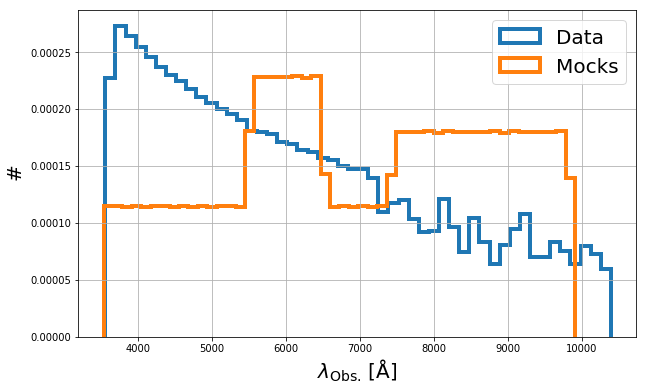

In [176]:
for name,vals in sorted(toPlot.items()):
    print(name, vals['WAVE'].min(), vals['WAVE'].max() )
    plt.hist(vals['WAVE'],bins=50,histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$\#$')
plt.legend()
plt.grid()
plt.show()

### Distribution of flux

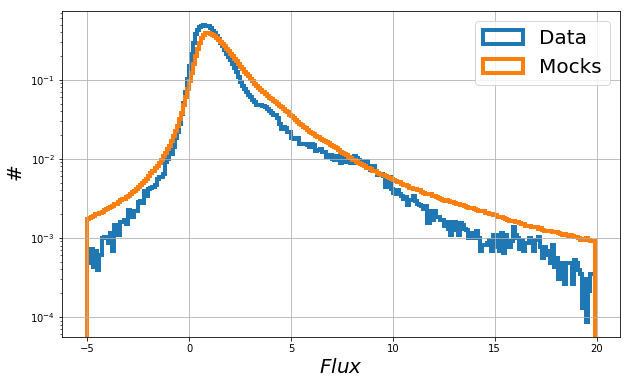

In [177]:
for name,vals in sorted(toPlot.items()):
    plt.hist(vals['FLUX'],bins=sp.arange(-5.,20.,0.1),histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$Flux$')
plt.ylabel(r'$\#$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

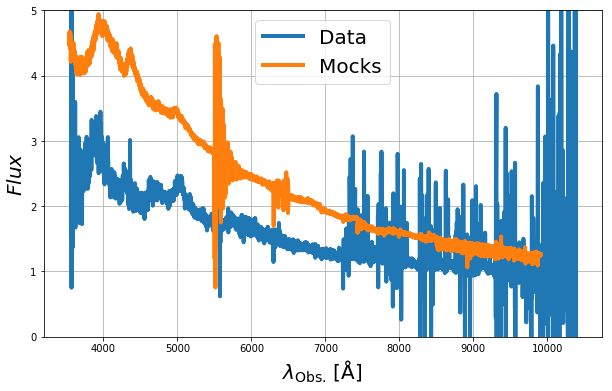

In [178]:
lObs_min = 2000.
lObs_max = 15000.

for name,vals in sorted(toPlot.items()):

    x = sp.arange(lObs_min,lObs_max,1.)
    bins = ( ( vals['WAVE']-lObs_min )/(lObs_max-lObs_min)*x.size ).astype(int)
    y = sp.bincount(bins,weights=vals['FLUX'],minlength=x.size)
    var = sp.bincount(bins,weights=vals['FLUX']**2,minlength=x.size)
    nb = sp.bincount(bins,minlength=x.size)
    w = nb>2.
    x = x[w]
    y = y[w]/nb[w]
    var = var[w]/nb[w] - y**2    
    plt.plot(x,y,linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$Flux$')
plt.legend()
plt.ylim([0.,5.])
plt.grid()
plt.show()

### Distribution of ivar

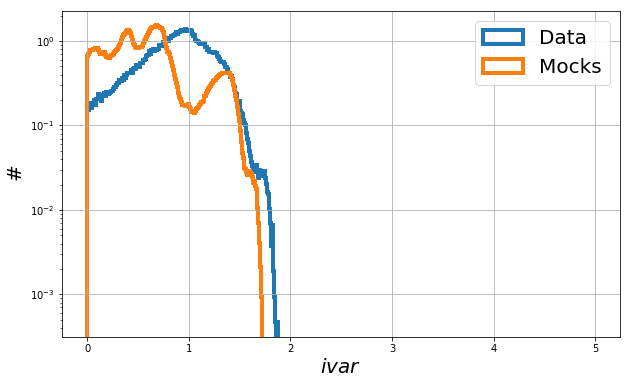

In [179]:
for name,vals in sorted(toPlot.items()):
    plt.hist(sp.log10(vals['IVAR']),bins=sp.arange(0.,5.,0.01),histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$ivar$')
plt.ylabel(r'$\#$')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

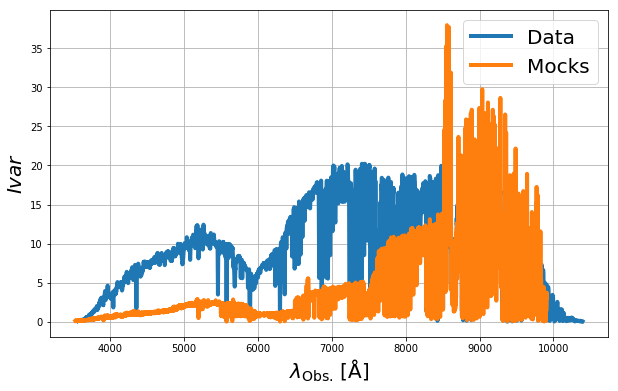

In [180]:
lObs_min = 2000.
lObs_max = 15000.

for name,vals in sorted(toPlot.items()):

    x = sp.arange(lObs_min,lObs_max,1.)
    bins = ( ( vals['WAVE']-lObs_min )/(lObs_max-lObs_min)*x.size ).astype(int)
    y = sp.bincount(bins,weights=vals['IVAR'],minlength=x.size)
    var = sp.bincount(bins,weights=vals['IVAR']**2,minlength=x.size)
    nb = sp.bincount(bins,minlength=x.size)
    
    w = nb>2.
    x = x[w]
    y = y[w]/nb[w]
    var = var[w]/nb[w] - y**2    
    plt.plot(x,y,linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$Ivar$')
plt.legend()
plt.grid()
plt.show()

### Distribution of SNR = flux * sp.sqrt(ivar)

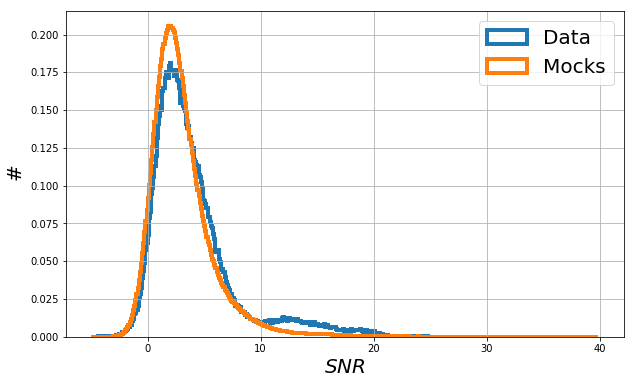

In [181]:
for name,vals in sorted(toPlot.items()):
    snr = vals['FLUX']*sp.sqrt(vals['IVAR'])
    plt.hist(snr,bins=sp.arange(-5.,40.,0.1),histtype='step',label=name,linewidth=4,density=True)
plt.xlabel(r'$SNR$')
plt.ylabel(r'$\#$')
#plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

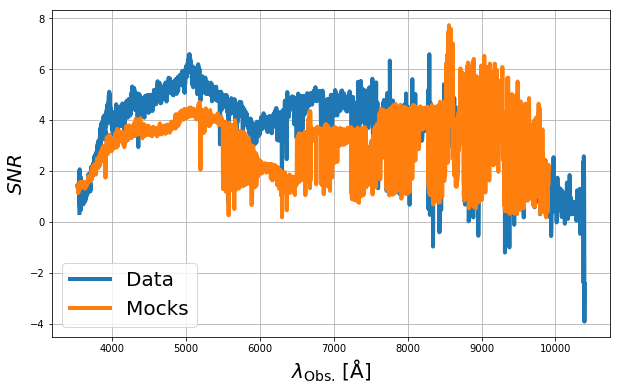

In [182]:
lObs_min = 2000.
lObs_max = 15000.

for name,vals in sorted(toPlot.items()):
    snr = vals['FLUX']*sp.sqrt(vals['IVAR'])
    x = sp.arange(lObs_min,lObs_max,1.)
    bins = ( ( vals['WAVE']-lObs_min )/(lObs_max-lObs_min)*x.size ).astype(int)
    y = sp.bincount(bins,weights=snr,minlength=x.size)
    var = sp.bincount(bins,weights=snr**2,minlength=x.size)
    nb = sp.bincount(bins,minlength=x.size)
    
    w = nb>2.
    x = x[w]
    y = y[w]/nb[w]
    var = var[w]/nb[w] - y**2    
    plt.plot(x,y,linewidth=4,label=name)
    
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, \mathrm{[\AA{}]}$')
plt.ylabel(r'$SNR$')
plt.legend()
plt.grid()
plt.show()

# __The delta field__

In [211]:
### List of all the delta attributes functions to plot
all_delta_attributes = {'Mock':mock['picca_delta_attributes'], 'Data':data['picca_delta_attributes']}

### Flux stack vs. observed wavelength

/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis//Delta_LYA/Log/delta_attributes.fits.gz
/project/projectdirs/desi/mocks/lya_forest/picca/saclay/v4.4/v4.4.0//eboss-0.2-test-ebossresolution///iter.fits.gz


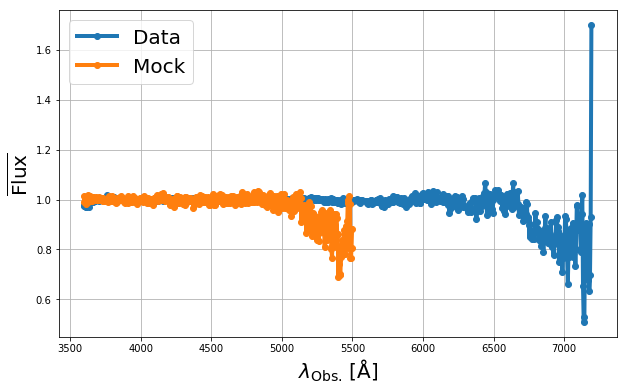

In [212]:
for name,path in sorted(all_delta_attributes.items()):
    print(path)
    h = fitsio.FITS(path)
    loglam = h[1]['LOGLAM'][:]
    stack  = h[1]['STACK'][:]
    w = h[1]['WEIGHT'][:]>0.
    loglam = loglam[w]
    stack  = stack[w]
    plt.plot(10.**loglam, stack, linewidth=4,marker='o',label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$\mathrm{\overline{Flux}}$')
plt.legend()
plt.grid()
plt.show()

### Mean continuum

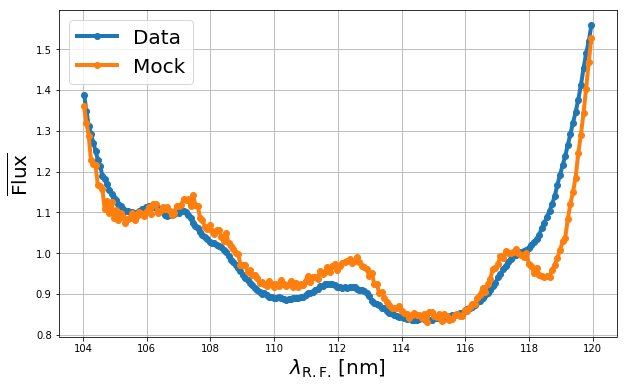

In [213]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam_rest = h[3]['LOGLAM_REST'][:]
    mean_cont = h[3]['MEAN_CONT'][:]
    w = h[3]['WEIGHT'][:]>0.
    loglam_rest = loglam_rest[w]
    mean_cont = mean_cont[w]
    plt.plot(10.**loglam_rest/10., mean_cont, linewidth=4,marker='o',label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\mathrm{nm}]$')
plt.ylabel(r'$\mathrm{\overline{Flux}}$')
plt.legend()
plt.grid()
plt.show()

### Correction to the pipeline variance

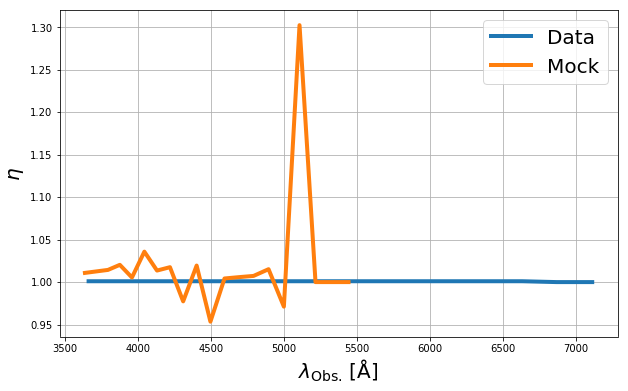

In [214]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    eta = h[2]['ETA'][:]
    w = h[2]['NB_PIXELS'][:]>0.
    loglam = loglam[w]
    eta = eta[w]
    plt.errorbar(10.**loglam, eta, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$\eta$')
plt.legend()
plt.grid()
plt.show()

### Large Scale Structure variance

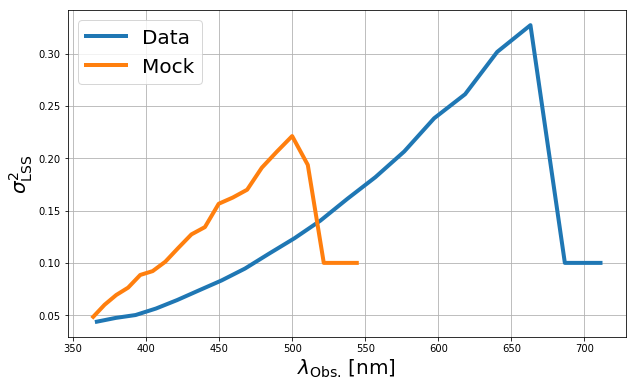

In [215]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    var_lss = h[2]['VAR_LSS'][:]
    w = h[2]['NB_PIXELS'][:]>0.
    loglam = loglam[w]
    var_lss = var_lss[w]
    plt.errorbar(10.**loglam/10., var_lss, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{nm}]$')
plt.ylabel(r'$\sigma^{2}_{\mathrm{LSS}}$')
plt.legend()
plt.grid()
plt.show()

### Let's look at the contribution of the variation of the continuum

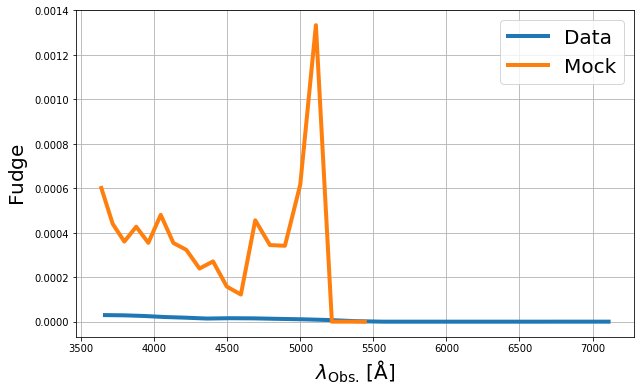

In [216]:
for name,path in sorted(all_delta_attributes.items()):
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    fudge = h[2]['FUDGE'][:]
    w = h[2]['NB_PIXELS'][:]>0
    loglam = loglam[w]
    fudge = fudge[w]
    plt.errorbar(10.**loglam, fudge, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{\AA{}}]$')
plt.ylabel(r'$\mathrm{Fudge}$')
plt.legend()
plt.grid()
plt.show()

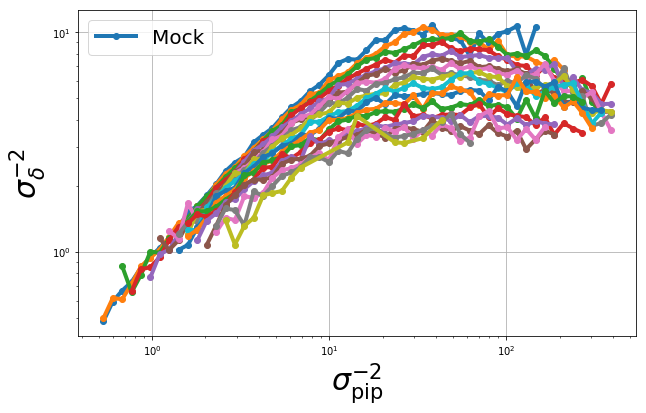

In [217]:
color = ['royalblue','darkorange']

for idx, (name,path) in enumerate(sorted(all_delta_attributes.items())[1:]):

    h = fitsio.FITS(path)

    var_pipe = h[4]['var_pipe'][:]
    var_del = h[4]['var_del'][:]
    var2_del = h[4]['var2_del'][:]
    count = h[4]['count'][:]
    nqsos = h[4]['nqsos'][:]
    chi2 = h[4]['chi2'][:]

    nb = var_pipe.shape[0]

    for i in range(nb):
        x = var_pipe[i,:]
        y = var_del[i,:]
        w = count[i,:]>100.
        if i==0:
            plt.plot(1./x[w], 1./y[w], 'o-', linewidth=4, label=name)
        else:
            plt.plot(1./x[w], 1./y[w], 'o-', linewidth=4)

plt.xlabel(r'$\sigma^{-2}_{\mathrm{pip}}$',fontsize=30)
plt.ylabel(r'$\sigma^{-2}_{\delta}$',fontsize=30)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

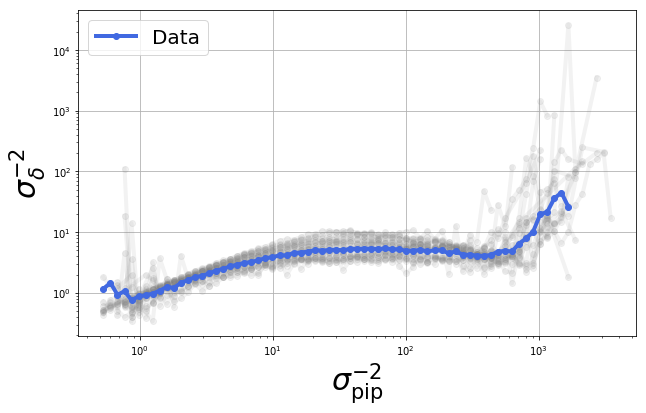

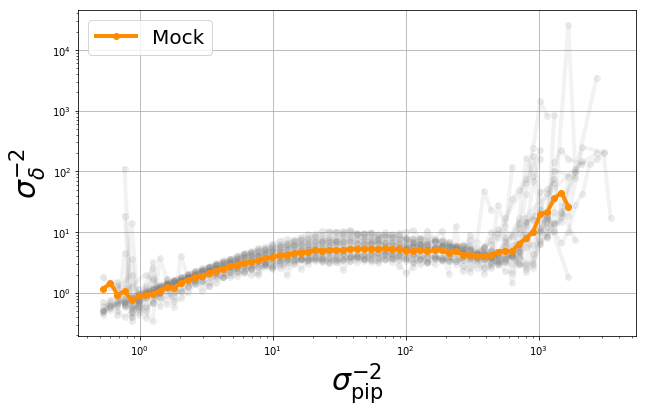

In [218]:
color = ['royalblue','darkorange']

for idx, (name,path) in enumerate(sorted(all_delta_attributes.items())):
    
    h = fitsio.FITS(path)
    
    for i in range(nb):
        x = var_pipe[i,:]
        y = var_del[i,:]
        w = count[i,:]>2.
        plt.plot(1./x[w], 1./y[w], 'o-', linewidth=4,color='grey',alpha=0.1)
    x = var_pipe.mean(axis=0)
    y = var_del.mean(axis=0)
    w = count.mean(axis=0)>2.
    plt.plot(1./x[w], 1./y[w], 'o-', linewidth=4,color=color[idx],label=name)

    plt.xlabel(r'$\sigma^{-2}_{\mathrm{pip}}$',fontsize=30)
    plt.ylabel(r'$\sigma^{-2}_{\delta}$',fontsize=30)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()

### 1D Correlation

In [46]:
### List of all the correlation to plot
all_cf1d = {'Mock':mock['picca_cf1d'],
            'Data':data['picca_cf1d']}

### The variance of delta in the forest

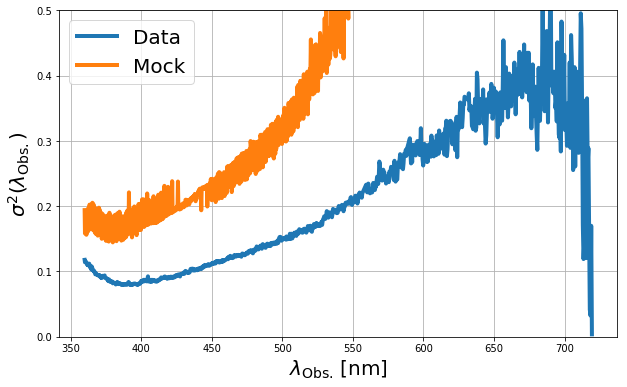

In [47]:
### The variance
for name,path in sorted(all_cf1d.items()):
    try:
        h = fitsio.FITS(path)
    except:
        print('Couldnt find file {}, skipping'.format(path))
        continue
    head = h[1].read_header() #- in the future replace '1' by '1DCOR'
    llmin = head['LLMIN']
    llmax = head['LLMAX']
    dll = head['DLL']
    n1d = int((llmax-llmin)/dll+1)
    x = sp.arange(0.,n1d)*dll+llmin
    y = h[1]['v1d'][:]
    w = h[1]['wv1d'][:]>0.
    x = x[w]
    y = y[w]
    plt.plot(10.**x/10.,y,linewidth=4,label=name)
    h.close()
plt.ylim([0.,0.5])
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\mathrm{nm}] $')
plt.ylabel(r'$\sigma^2(\lambda_{\mathrm{Obs.}})$')
plt.legend()
plt.grid()
plt.show()

### The normalized correlation in the forest

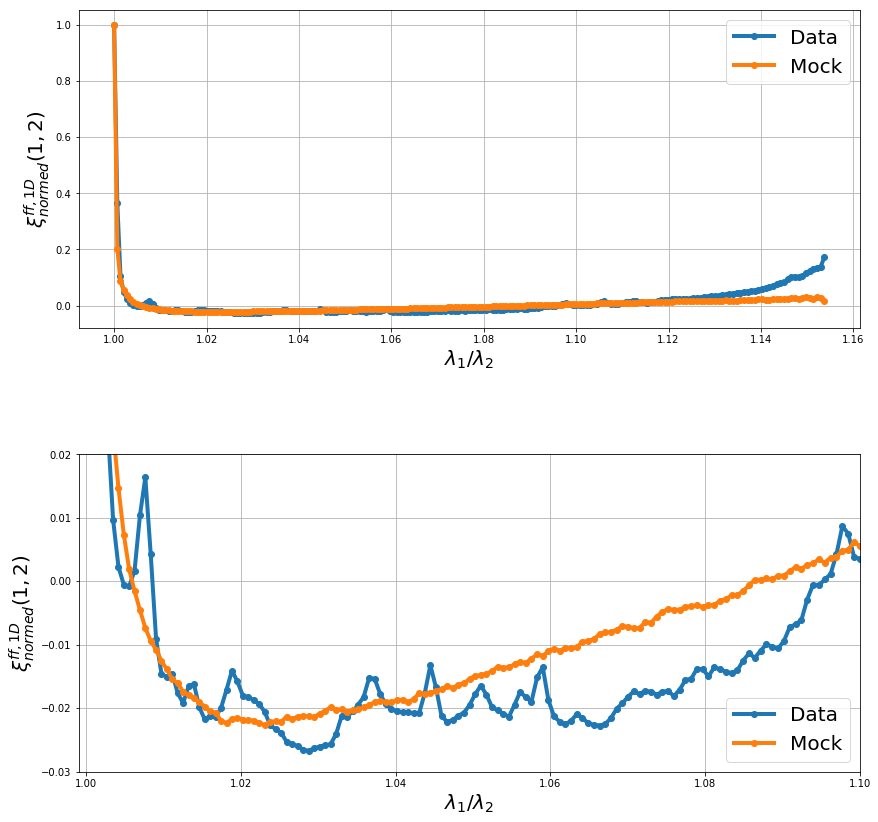

In [48]:
### The normalized correlation
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))

### all
for name,path in sorted(all_cf1d.items()):
    try:
        h = fitsio.FITS(path)
    except:
        print('cant find {}, skipping'.format(path))
        continue
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    ax1.errorbar(x,y,marker='o',linewidth=4,label=name)
    h.close()
ax1.set_xlabel(r'$\lambda_{1}/\lambda_{2}$')
ax1.set_ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$')
ax1.legend()
ax1.grid()

### zoom
ymin = 1.e6
ymax = -1.e6
for name,path in sorted(all_cf1d.items()):
    try:
        h = fitsio.FITS(path)
    except:
        print("Can't find file {}, skipping".format(path))
        continue
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    ymin = min(ymin,y.min())
    ymax = max(ymax,y[y!=1.].max())
    ax2.errorbar(x,y,marker='o',linewidth=4,label=name)
    h.close()
ax2.set_xlim([0.999,1.1])
ax2.set_ylim([-0.03,0.02])
ax2.set_xlabel(r'$\lambda_{1}/\lambda_{2}$')
ax2.set_ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$')
ax2.legend()
ax2.grid()

plt.subplots_adjust(hspace=0.4)
plt.show()

# __Fit results__

The cell below will print out a table with the fit parameters for the auto results.
If you want the cross results instead change the first line to

    fi = sorted(glob.glob("xcf*.h5"))

In [8]:
#fi = sorted(glob.glob(data['picca']+'/Correlations/Fit/cf_z_*_noMet/result.h5'))[:1]
fi = sorted(glob.glob(mock['picca']+'/cf_z*.h5'))
#print(mock['picca']+'cf_z*.h5')
ff = h5py.File(fi[0],'r')
cosmo_pars = ['bias_LYA',"bias_eta_LYA","beta_LYA","bias_eta_QSO","beta_QSO","ap","at"]
all_pars = [p.decode('utf-8') for p in ff['best fit'].attrs['list of free pars']]
bname0 = fi[0].replace(".h5","")
ff.close()

print("{:20}".format(""),end="")
for f in fi:
    print("{:^20}".format(f.replace(mock['picca'],'').replace("-exp.h5","")),end="")
print("")

print("{:20}".format("zeff"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        zeff = ff['best fit'].attrs['zeff']
    except:
        print("PROBLEM: {}".format(f))
        continue
    out = "{}".format(round(zeff,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

for par in cosmo_pars:
    print("{:20}".format(par),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        if par in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[par]
            out = "{} +/- {}".format(round(p,3), round(dp,3))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
    
for par in all_pars:
    if par in cosmo_pars:
        continue
    print("{:20}".format(par[:20]),end="")
    for f in fi:
        ff = h5py.File(f,'r')
        bname = f.replace(".h5","")
        pa = par.replace(bname0,bname)
        if pa in ff['best fit'].attrs:
            p,dp = ff['best fit'].attrs[pa]
            out = "{} +/- {}".format(round(p,3), round(dp,3))
            print("{:^20}".format(out),end="")
        ff.close()
    print("")
print("{:20}".format("chi2/(ndata-npar)"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        chi2 = ff['best fit'].attrs['fval']
    except:
        continue
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    out = "{}/({}-{})".format(round(chi2,1),ndata,npar)
    print("{:^20}".format(out),end="")
    ff.close()
print("")
print("{:20}".format("probability"),end="")
for f in fi:
    ff = h5py.File(f,'r')
    try:
        chi2 = ff['best fit'].attrs['fval']
    except:
        continue
    ndata = ff['best fit'].attrs['ndata']
    npar = ff['best fit'].attrs['npar']
    proba = 1.-sp.stats.chi2.cdf(chi2,ndata-npar)
    out = "{}".format(round(proba,2))
    print("{:^20}".format(out),end="")
    ff.close()
print("")

                    /project/projectdirs/desi/mocks/lya_forest/picca/saclay/v4.4/v4.4.0//eboss-0.2-test-ebossresolution/cf_z_0_10
zeff                        2.31        
bias_LYA            
bias_eta_LYA          -0.23 +/- 0.005   
beta_LYA               0.962 +/- 0.03   
bias_eta_QSO        
beta_QSO            
ap                    1.037 +/- 0.031   
at                    0.949 +/- 0.033   
par binsize cf_z_0_1  13.505 +/- 0.247  
per binsize cf_z_0_1  14.642 +/- 0.497  
chi2/(ndata-npar)     1730.7/(1590-6)   
probability                 0.01        


# Wedge plots

The cells below display wedge plots for a given file.

Change the value of `base` to the file you wish to display.

In [13]:
base = 'cf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base}
if data['forest']=='LYA':
    base = 'cf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

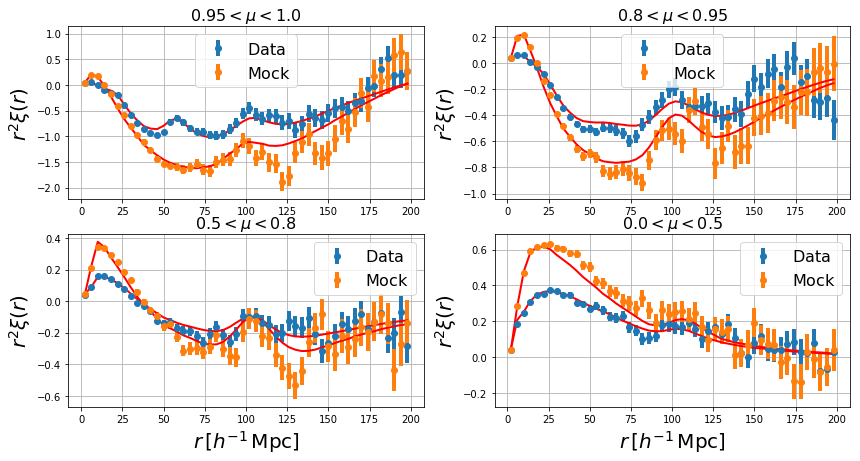

In [14]:
mus = [1., 0.95, 0.8, 0.5, 0.]
power = 2
f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i, (mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for j,(name,paths) in enumerate(sorted(toPlot.items())):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o",label=r'$\mathrm{'+name+'}$')
        axs[i//2][i%2].plot(r,f*r**power,linewidth=2,color='red')
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

In [16]:
base = 'xcf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base }
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

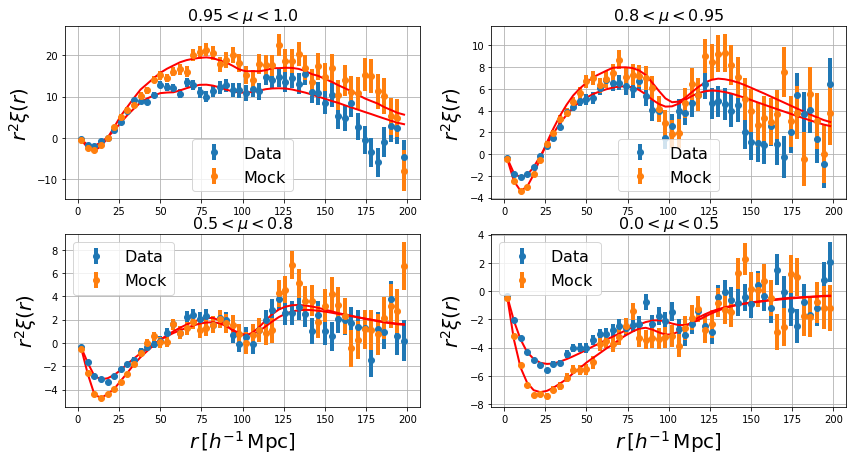

In [17]:
mus = [1., 0.95, 0.8, 0.5, 0.]
power = 2
f, (axs) = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

for i,(mumax,mumin) in enumerate(zip(mus[:-1],mus[1:])):
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        axs[i//2][i%2].errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o",label=r'$\mathrm{'+name+'}$')
        axs[i//2][i%2].plot(r,f*r**power,color='red',linewidth=2)
    axs[i//2][i%2].set_ylabel(r"$r^2\xi(r)$")
    if i//2==1:
        axs[i//2][i%2].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    axs[i//2][i%2].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    axs[i//2][i%2].legend(fontsize=16)
    axs[i//2][i%2].grid()
plt.show()

# Slices plots

In [18]:
base = '/cf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':'cf_z_0_10-exp'}
base = 'cf_z_0_10'
toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

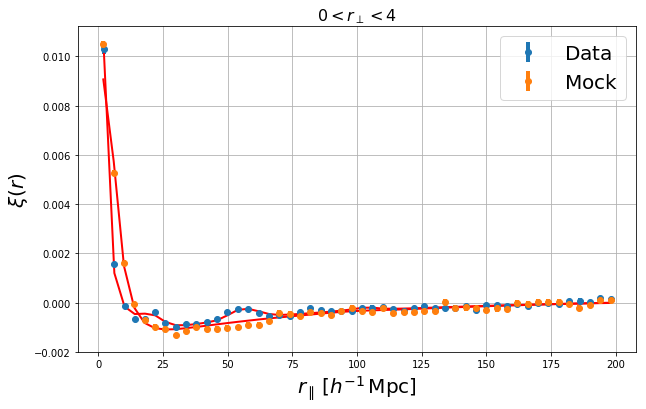

In [19]:
slices = [0]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
base = 'xcf_z_0_10-exp'
toPlot = {}
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base }
#toPlot['Mockbefore'] = { 'CORR':mock['picca'].replace('eboss-0.1','eboss-0.1_backup_noSiII1260')+'/'+base+'.fits', 'FIT':mock['picca']+'/'+base+'.h5', 'NAME':base }
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

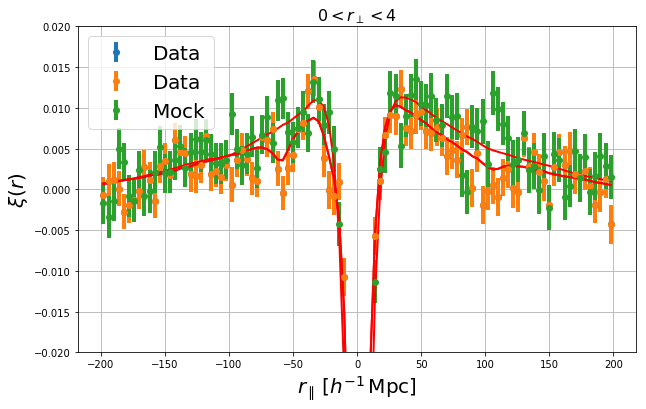

In [23]:
slices = [0]
for s in slices:
    for name,paths in sorted(toPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.ylim([-0.02,0.02])
    plt.legend()
    plt.grid()
    plt.show()

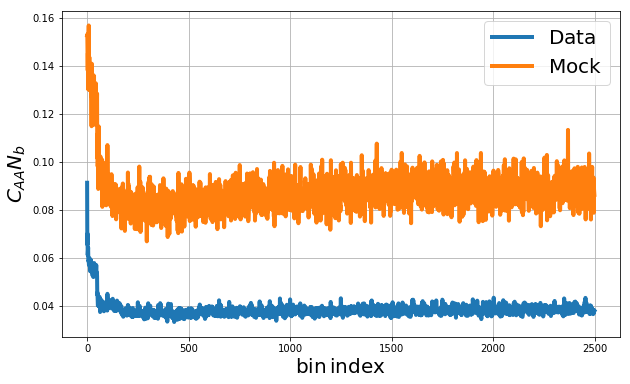

In [24]:
### The auto-correlation
toPlot = {}
base = 'cf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'cf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    co = sp.diag(h[1]['CO'][:])
    plt.plot(nb*co,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$C_{AA} N_{b}$")
plt.legend()
plt.grid()
plt.show()

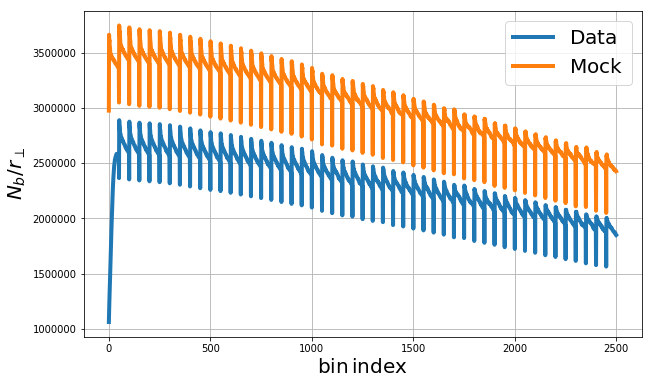

In [25]:
### The auto-correlation
toPlot = {}
base = 'cf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'cf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    rt = h[1]['RT'][:]
    plt.plot(nb/rt,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$N_{b}/r_{\perp}$")
plt.legend()
plt.grid()
plt.show()

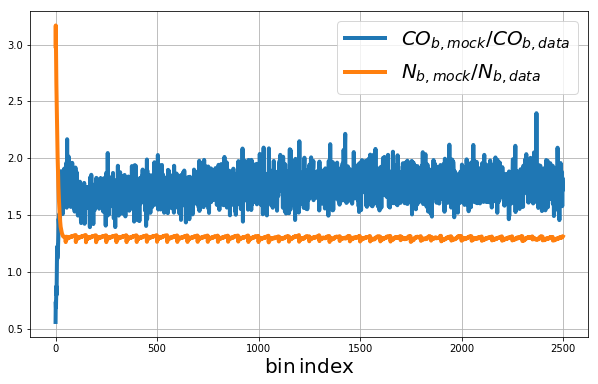

In [26]:
### The auto-correlation
toPlot = {}
base = 'cf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'cf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

h = fitsio.FITS(toPlot['Mock']['CORR'])
nbm = h[1]['NB'][:]
com = sp.diag(h[1]['CO'][:])
h.close()
h = fitsio.FITS(toPlot['Data']['CORR'])
nbd = h[1]['NB'][:]
cod = sp.diag(h[1]['CO'][:])
h.close()

plt.plot(com/cod,label=r"$CO_{b,mock}/CO_{b,data}$")
plt.plot(nbm/nbd,label=r"$N_{b,mock}/N_{b,data}$")
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.legend()
plt.grid()
plt.show()

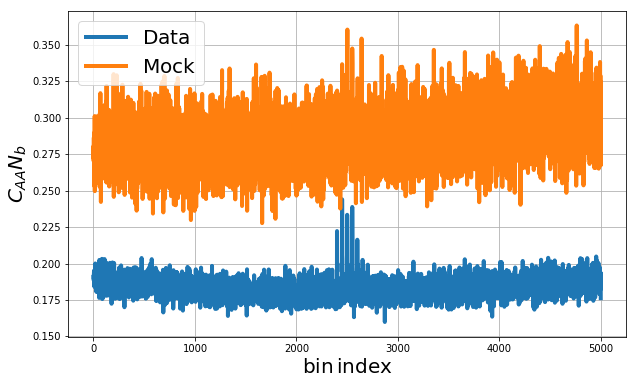

In [27]:
### The cross-correlation
toPlot = {}
base = 'xcf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    co = sp.diag(h[1]['CO'][:])
    plt.plot(nb*co,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$C_{AA} N_{b}$")
plt.legend()
plt.grid()
plt.show()

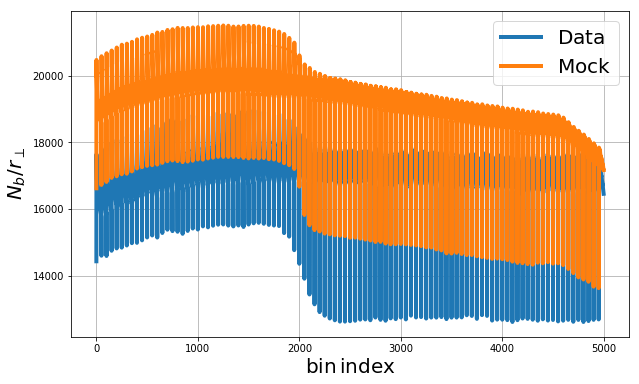

In [28]:
### The cross-correlation
toPlot = {}
base = 'xcf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

for name,paths in sorted(toPlot.items()):
    h = fitsio.FITS(paths['CORR'])
    nb = h[1]['NB'][:]
    rt = h[1]['RT'][:]
    plt.plot(nb/rt,label=r'$\mathrm{'+name+'}$')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.ylabel(r"$N_{b}/r_{\perp}$")
plt.legend()
plt.grid()
plt.show()

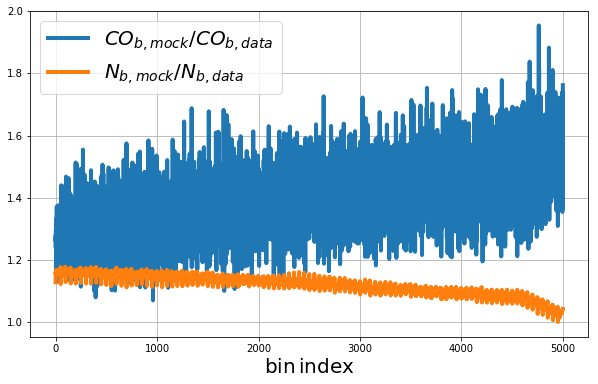

In [29]:
### The auto-correlation
toPlot = {}
base = 'xcf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

h = fitsio.FITS(toPlot['Mock']['CORR'])
nbm = h[1]['NB'][:]
com = sp.diag(h[1]['CO'][:])
h.close()
h = fitsio.FITS(toPlot['Data']['CORR'])
nbd = h[1]['NB'][:]
cod = sp.diag(h[1]['CO'][:])
h.close()

plt.plot(com/cod,label=r"$CO_{b,mock}/CO_{b,data}$")
plt.plot(nbm/nbd,label=r"$N_{b,mock}/N_{b,data}$")
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.legend()
plt.grid()
plt.show()

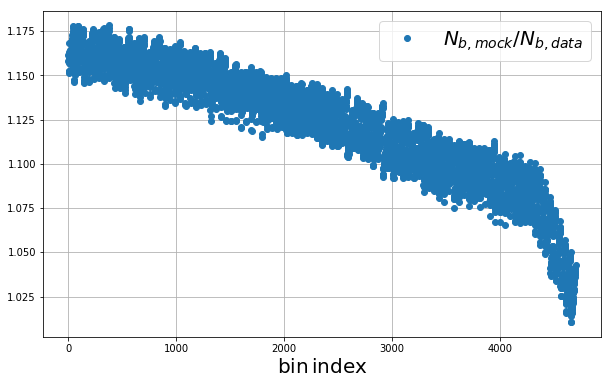

In [30]:
### The auto-correlation
toPlot = {}
base = 'xcf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}

h = fitsio.FITS(toPlot['Mock']['CORR'])
nbm = h[1]['NB'][:]
rp = h[1]['RP'][:]
rt = h[1]['RT'][:]
h.close()
h = fitsio.FITS(toPlot['Data']['CORR'])
nbd = h[1]['NB'][:]
h.close()

w = rt>12.
plt.errorbar(sp.arange(rt[w].size),(nbm/nbd)[w],label=r"$N_{b,mock}/N_{b,data}$",fmt='o')
plt.xlabel(r"$\mathrm{bin\,index}$")
plt.legend()
plt.grid()
plt.show()

# The correlation matrix

Let's look at the difference between the data and the mocks on the correlation matrix

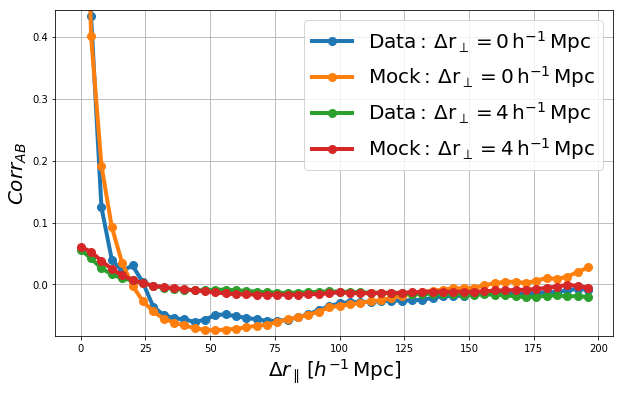

In [31]:
### The auto-correlation
toPlot = {}
base = 'cf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'cf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'/Correlations/Fit/'+base+'/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    data['picca_n'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/Data/eBOSS/picca_DR16_paper_analysis_new/'
    base = 'cf_LYA_in_LYA_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca_n']+'/Correlations/'+base+'-exp.fits.gz',
                      'FIT':data['picca_n']+'/Correlations/Fit/'+base+'_met/result.h5',
                      'NAME': base}

### Load
corr = {}
for name,paths in sorted(toPlot.items()):
    corr[name] = {}
    h = fitsio.FITS(paths['CORR'])
    corr[name]['CO'] = h[1]['CO'][:]
    tvar = sp.diag(corr[name]['CO'])
    corr[name]['NBBIN'] = tvar.size
    corr[name]['NT'] = h[1].read_header()['NT']
    corr[name]['BINSIZE'] = h[1].read_header()['RTMAX']/h[1].read_header()['NT']
    tcor = corr[name]['CO']/sp.sqrt(tvar*tvar[:,None])
    corr[name]['COR'] = tcor.copy()
    h.close()

### Plot
ymin = 1.
ymax = -1.
for j in range(2):
    for name,tc in sorted(corr.items()):
        c = tc['COR'].copy()
        a = sp.array( [ sp.mean(sp.diagonal(c, offset=(tc['NT']*i+j))) for i in range(tc['NBBIN']//tc['NT']) ])
        label = '\mathrm{'+name+': \, \Delta r_{\perp} = '+str(int(tc['BINSIZE']*j))+'\,h^{-1}\, \mathrm{Mpc}}'
        plt.plot(tc['BINSIZE']*sp.arange(tc['NBBIN']//tc['NT']),a,linewidth=4,marker='o',markersize=8, label=r'$'+label+'$')
        ymin = min(ymin,a.min())
        ymax = max(ymax,a[a!=1.].max())
plt.xlabel(r'$\Delta r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$')
plt.ylabel(r'$Corr_{AB}$')
#plt.xlim([-1.,100.])
plt.ylim([ymin-0.01,ymax+0.01])
plt.legend()
plt.grid()
plt.show()

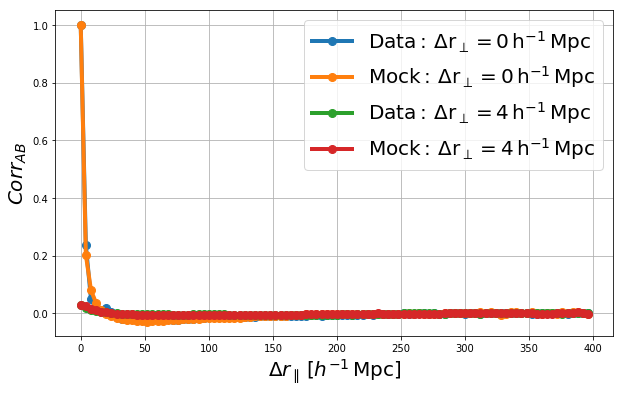

In [32]:
### The cross-correlation
toPlot = {}
base = 'xcf_z_0_10'
toPlot['Mock'] = { 'CORR':mock['picca']+'/'+base+'-exp.fits'}
if data['forest']=='LYA':
    base = 'xcf_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'_noHCD/result.h5', 'NAME': base}
elif data['forest']=='LYB':
    base = 'xcf_LYA_in_LYB_z_0_10'
    toPlot['Data'] = { 'CORR':data['picca']+'/Correlations/'+base+'-exp.fits.gz', 'FIT':data['picca']+'Correlations/Fit/'+base+'/result.h5', 'NAME': base}


### Load
corr = {}
for name,paths in sorted(toPlot.items()):
    corr[name] = {}
    h = fitsio.FITS(paths['CORR'])
    corr[name]['CO'] = h[1]['CO'][:]
    tvar = sp.diag(corr[name]['CO'])
    corr[name]['NBBIN'] = tvar.size
    corr[name]['NT'] = h[1].read_header()['NT']
    corr[name]['BINSIZE'] = h[1].read_header()['RTMAX']/h[1].read_header()['NT']
    tcor = corr[name]['CO']/sp.sqrt(tvar*tvar[:,None])
    corr[name]['COR'] = tcor.copy()
    h.close()

### Plot
ymin = 1.
ymax = -1.
for j in range(2):
    for name,tc in sorted(corr.items()):
        c = tc['COR'].copy()
        a = sp.array( [ sp.mean(sp.diagonal(c, offset=(tc['NT']*i+j))) for i in range(tc['NBBIN']//tc['NT']) ])
        label = '\mathrm{'+name+': \, \Delta r_{\perp} = '+str(int(tc['BINSIZE']*j))+'\,h^{-1}\, \mathrm{Mpc}}'
        plt.plot(tc['BINSIZE']*sp.arange(tc['NBBIN']//tc['NT']),a,linewidth=4,marker='o',markersize=8, label=r'$'+label+'$')
        ymin = min(ymin,a.min())
        ymax = max(ymax,a[a!=1.].max())
plt.xlabel(r'$\Delta r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$')
plt.ylabel(r'$Corr_{AB}$')
#plt.xlim([-1.,100.])
#plt.ylim([0.,1.])#[ymin-0.01,ymax+0.01])
plt.legend()
plt.grid()
plt.show()

## __Compare fit results to data or theory__

Redshift bins

In [33]:
zint = ['0:2.35','2.35:2.65','2.65:3.05','3.05:10','0:10']
#zint = ["0:2.2","2.2:2.4","2.4:2.6","2.6:2.8","2.8:3.0","3.0:3.2","3.2:10",'0:10']
zint_data = ['0:2.35','2.35:2.65','2.65:3.05','3.05:10','0:10']
#zint_data = ['0:10']

Useful function to get bias and growth rate of structure

In [34]:
def alpha(z,a0,a1,zeff=2.30):
    evol = a0*((1.+z)/(1.+zeff))**a1
    return evol
def bias_vs_z_std(z, zref, alpha):
    r = ((1.+z)/(1+zref))**alpha
    return r
def growthRateStructure(z, omega_M_0=0.315):
    omega_m = omega_M_0*(1.+z)**3 / ( omega_M_0*(1.+z)**3+(1.-omega_M_0))
    f = sp.power(omega_m,0.55)
    return f

Get the effective redshift of each correlation

In [35]:
weTot = 0.
zeffTot = 0.
    
for cor in ['cf','xcf']:
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        corr = mock['picca']+'/{}_z_{}_{}.fits'.format(cor,zmin,zmax)

        try:
            h = fitsio.FITS(corr)
        except:
            print('WARNING: doesnt exist: ', corr)
            continue
        we = h['COR']['WE'][:]
        we = we.sum(axis=0)
        z = h['ATTRI']['Z'][:]
        rp = h['ATTRI']['RP'][:]
        rt = h['ATTRI']['RT'][:]
        r = sp.sqrt(rp**2. + rt**2.)
        w = (r>80.) & (r<120.)

        zeff = sp.sum( z[w]*we[w] )/sp.sum( we[w] )
        zeffTot = zeffTot*weTot + sp.sum( z[w]*we[w] )
        weTot += sp.sum( we[w] )
        zeffTot /= weTot

        h.close()
        f = growthRateStructure(zeff)
        bias = bias_vs_z_std(zeff, zref=0.37, alpha=1.44)
        beta = f/bias
        
        print(corr.replace(mock['picca']+'/',''), zeff, f, bias, beta)

f = growthRateStructure(zeffTot)
bias = bias_vs_z_std(zeffTot, zref=0.37, alpha=1.44)
beta = f/bias
print('Tot', zeffTot, f, bias, beta)

cf_z_0_10.fits 2.284491832803353 0.967771081764816 3.5223829604490153 0.2747489675686625
xcf_z_0_10.fits 2.3298151355373156 0.969013093212131 3.592587549573199 0.26972567260810393
Tot 2.284609649862964 0.9677743936482989 3.522564906437311 0.2747357165455602


Fit to plots

In [36]:
toPlot = {}

In [37]:
### Mocks
### Individuals
lst = ['cf']
### Combined
#lst = ['cfxcf']
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in lst:
        toPlot['Mock-{}-z-{}-{}'.format(cor,zmin,zmax)] = {
            'CORR':mock['picca']+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
            'FIT':mock['picca']+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
            'NAME':'{}_z_{}_{}'.format(cor,zmin,zmax),
            'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

In [38]:
### Data
### Individuals
if data['forest']=='LYA':
    lst = ['cf']
elif data['forest']=='LYB':
    lst = ['cf_LYA_in_LYB']
### Combined
#lst = ['cfxcf']
for zinterval in zint_data:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in lst:
        name = '{}_z_{}_{}'.format(cor,zmin,zmax)
        name2 = name.replace('_','-')
        if '0_10' in name and cor=='xcf':
            fmt = '_noHCD'
        else:
            fmt = ''
        toPlot['Data-{}'.format(name2)] = {
                'CORR':data['picca']+'/Correlations/{}-exp.fits.gz'.format(name),
                'FIT':data['picca']+'/Correlations/Fit/{}{}/result.h5'.format(name,fmt),
                'NAME':'{}'.format(name2),
                'TITLE':'{}'.format(name2)}

Load the fit results

In [39]:
for name,paths in sorted(toPlot.items()):

    if not os.path.isfile(os.path.expandvars(paths['FIT'])):
        print(' WARNING: does not exist ', paths['FIT'])
        continue

    h = fitsio.FITS(toPlot[name]['CORR'])
    try:
        sp.linalg.cholesky(h[1]['CO'][:])
        print('ok: ', name)
    except sp.linalg.LinAlgError:
        print('WARNING: Matrix is not positive definite: ', name)
        continue
    h.close()
    
    f = h5py.File(os.path.expandvars(paths['FIT']),'r')
    toPlot[name]['FIT_RES'] = {}
    toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
    for k in list(f['best fit'].attrs['list of free pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    for k in list(f['best fit'].attrs['list of fixed pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    f.close()

ok:  Data-cf-z-0-10
ok:  Data-cf-z-0-2.35
ok:  Data-cf-z-2.35-2.65
ok:  Data-cf-z-2.65-3.05
ok:  Data-cf-z-3.05-10
ok:  Mock-cf-z-0-10


### The BAO parameters

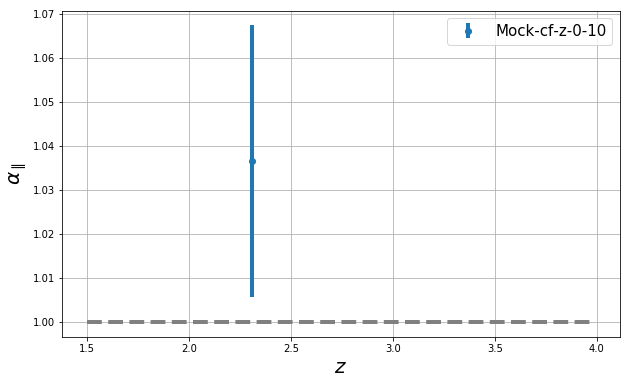

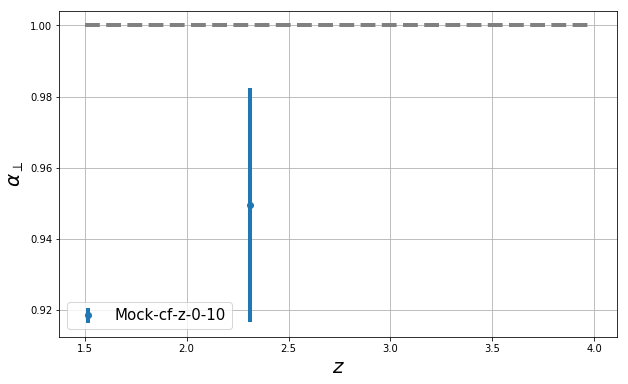

In [40]:
z = sp.arange(1.5,4.,0.01)
latexname = {'ap':'\\alpha_{\parallel}', 'at':'\\alpha_{\perp}'}
for p in ['ap','at']:
    plt.plot(z,sp.ones(z.size),'--',linewidth=4,color='grey')
    for name,vals in toPlot.items():
        if 'Data' in name: continue
        if 'FIT_RES' not in vals.keys(): continue
        lst = [ vals['FIT_RES']  ]
        xxx = sp.array([ el['ZEFF'] for el in lst ])
        yyy = sp.array([ el[p][0] for el in lst ])
        zzz = sp.array([ el[p][1] for el in lst ])
        if 'Mock' in name and '0-10' not in name:
            plt.errorbar(xxx,yyy,zzz,fmt='o',color='black')
        elif 'Data' in name and '0-10' not in name:
            plt.errorbar(xxx,yyy,zzz,fmt='o',color='green')
        else:
            plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)
    plt.xlabel(r'$z$')
    plt.ylabel(r'$'+latexname[p]+'$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The bias of Lya

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/ipykernel_launcher.py:32: HesseFailedWarning: HESSE Failed. Covariance and GlobalCC will not be available


a0 = 1.0 +/- 0.0
a1 = 1.0 +/- 0.0
[[ 2.13781251 -0.18558474  0.00650885]
 [ 2.27259149 -0.20089904  0.00566513]
 [ 2.54744584 -0.23754895  0.00859699]
 [ 2.9263245  -0.28984325  0.01907289]]
a0 = -0.20486881123158482 +/- 0.0037924446161117613
a1 = 2.0086360783988595 +/- 0.28299047995608956


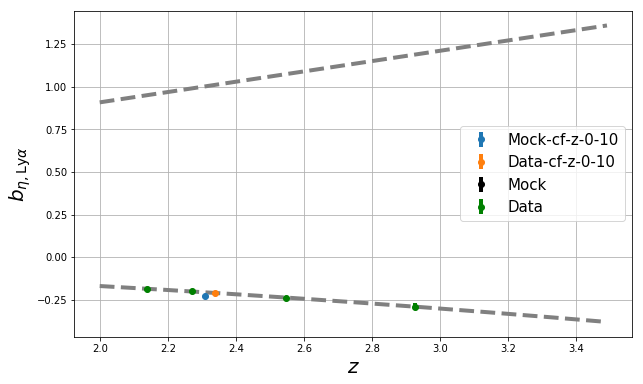

In [41]:
for name,vals in toPlot.items():
    if not 'FIT_RES' in vals.keys(): continue
    if 'Mock' in name and '0-10' not in name:
        continue
    elif 'Data' in name and '0-10' not in name:
        continue
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    try:
        yyy = sp.array([ el['bias_eta_LYA'][0] for el in lst ])
        zzz = sp.array([ el['bias_eta_LYA'][1] for el in lst ])
    except:
        yyy = sp.array([ el['bias_LYA'][0] for el in lst ])
        zzz = sp.array([ el['bias_LYA'][1] for el in lst ])
    plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)

### (Mocks) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Data' in name) and (not '0-10' in name) and ('FIT_RES' in vals.keys()) ]
xxx = sp.array([ el['ZEFF'] for el in cor ])
yyy = sp.array([ el['bias_eta_LYA'][0] for el in cor ])
err = sp.array([ el['bias_eta_LYA'][1] for el in cor ])
w = sp.isfinite(err)
xxx = xxx[w]
yyy = yyy[w]
err = err[w]
plt.errorbar(xxx,yyy,err,fmt='o',color='black',label='Mock')
def chi2(a0,a1):
    r = sp.sum( (yyy-alpha(xxx,a0,a1))**2/(err**2) )
    return r
m = Minuit(chi2, a0=1.,error_a0=1., a1=1.,error_a1=1.,print_level=-1, errordef=1.)
m.migrad()
m.hesse()
for p in m.values.keys():
    print(p, '=', m.values[p], '+/-', m.errors[p])
xxx = sp.arange(2.0, 3.5, 0.01)
plt.plot(xxx,alpha(xxx,m.values['a0'],m.values['a1']),'--',color='grey')

### (Data) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Mock' in name) and (not '0-10' in name) ]
xxx = sp.array([ el['ZEFF'] for el in cor ])
try:
    yyy = sp.array([ el['bias_eta_LYA'][0] for el in cor ])
    err = sp.array([ el['bias_eta_LYA'][1] for el in cor ])
except:
    yyy = sp.array([ el['bias_LYA'][0] for el in cor ])
    err = sp.array([ el['bias_LYA'][1] for el in cor ])
w = sp.isfinite(err)
xxx = xxx[w]
yyy = yyy[w]
err = err[w]
print(sp.array(list(zip(xxx,yyy,err))))
plt.errorbar(xxx,yyy,err,fmt='o',color='green',label='Data')
def chi2(a0,a1):
    r = sp.sum( (yyy-alpha(xxx,a0,a1))**2/(err**2) )
    return r
m = Minuit(chi2, a0=1.,error_a0=1., a1=1.,error_a1=1.,print_level=-1, errordef=1.)
m.migrad()
m.hesse()
for p in m.values.keys():
    print(p, '=', m.values[p], '+/-', m.errors[p])
xxx = sp.arange(2.0, 3.5, 0.01)
plt.plot(xxx,alpha(xxx,m.values['a0'],m.values['a1']),'--',color='grey')

plt.xlabel(r'$z$')
plt.ylabel(r'$b_{\eta, \mathrm{Ly}\alpha}$')
plt.legend(fontsize=15)
plt.grid()
plt.show()

### The beta of Lya

/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/ipykernel_launcher.py:29: HesseFailedWarning: HESSE Failed. Covariance and GlobalCC will not be available


a0 = 1.0 +/- 0.0
a1 = 1.0 +/- 0.0
[[2.13781251 1.71518188 0.14670333]
 [2.27259149 1.63599596 0.12377548]
 [2.54744584 1.34603853 0.10685724]
 [2.9263245  1.20116875 0.16525412]]
a0 = 1.5768541682349286 +/- 0.07301900558352674
a1 = -1.7873575282256318 +/- 0.6456249601598243


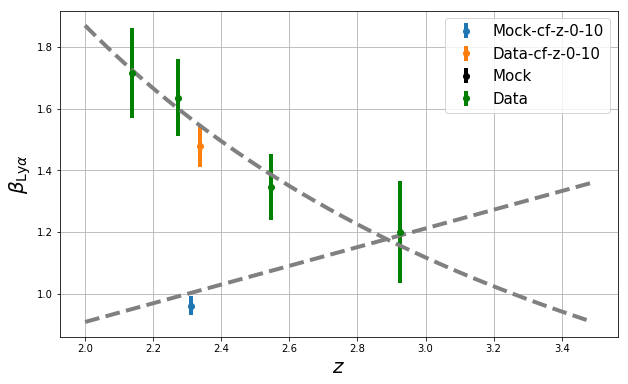

In [42]:
for name,vals in toPlot.items():
    if not 'FIT_RES' in vals.keys(): continue
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    yyy = sp.array([ el['beta_LYA'][0] for el in lst ])
    zzz = sp.array([ el['beta_LYA'][1] for el in lst ])
    if 'Mock' in name and '0-10' not in name:
        continue
    elif 'Data' in name and '0-10' not in name:
        continue
    else:
        plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)

### (Mock) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Data' in name) and (not '0-10' in name) and ('FIT_RES' in vals.keys()) ]
xxx = sp.array([ el['ZEFF'] for el in cor ])
yyy = sp.array([ el['beta_LYA'][0] for el in cor ])
err = sp.array([ el['beta_LYA'][1] for el in cor ])
w = sp.isfinite(err)
xxx = xxx[w]
yyy = yyy[w]
err = err[w]
plt.errorbar(xxx,yyy,err,fmt='o',color='black',label='Mock')
def chi2(a0,a1):
    r = sp.sum( (yyy-alpha(xxx,a0,a1))**2/(err**2) )
    return r
m = Minuit(chi2, a0=1.,error_a0=1., a1=1.,error_a1=1.,print_level=-1, errordef=1.)
m.migrad()
m.hesse()
for p in m.values.keys():
    print(p, '=', m.values[p], '+/-', m.errors[p])
xxx = sp.arange(2.0, 3.5, 0.01)
plt.plot(xxx,alpha(xxx,m.values['a0'],m.values['a1']),'--',color='grey')

### (Data) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Mock' in name) and (not '0-10' in name) ]
xxx = sp.array([ el['ZEFF'] for el in cor ])
yyy = sp.array([ el['beta_LYA'][0] for el in cor ])
err = sp.array([ el['beta_LYA'][1] for el in cor ])
w = sp.isfinite(err)
xxx = xxx[w]
yyy = yyy[w]
err = err[w]
print(sp.array(list(zip(xxx,yyy,err))))
plt.errorbar(xxx,yyy,err,fmt='o',color='green',label='Data')
def chi2(a0,a1):
    r = sp.sum( (yyy-alpha(xxx,a0,a1))**2/(err**2) )
    return r
m = Minuit(chi2, a0=1.,error_a0=1., a1=1.,error_a1=1.,print_level=-1, errordef=1.)
m.migrad()
m.hesse()
for p in m.values.keys():
    print(p, '=', m.values[p], '+/-', m.errors[p])
xxx = sp.arange(2.0, 3.5, 0.01)
plt.plot(xxx,alpha(xxx,m.values['a0'],m.values['a1']),'--',color='grey')

plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{\mathrm{Ly}\alpha}$')
plt.legend(fontsize=15)
plt.grid()
plt.show()

### The proper bias of Lya

Mock-cf-z-0-10 [2.31] [-0.23052897]
Data-cf-z-0-10 [2.33868959] [-0.13650705]
a0 = 1.0 +/- 0.0
a1 = 1.0 +/- 0.0
[2.13781251 2.27259149 2.54744584 2.9263245 ] [-0.104228   -0.11880018 -0.17192332 -0.23666178] [0. 0. 0. 0.]
a0 = -0.1260603909609097 +/- 0.5940202831228657
a1 = 3.631364403558357 +/- 36.06694786173977


/global/homes/h/hdumasde/.conda/envs/picca_plots/lib/python3.6/site-packages/ipykernel_launcher.py:36: HesseFailedWarning: HESSE Failed. Covariance and GlobalCC will not be available


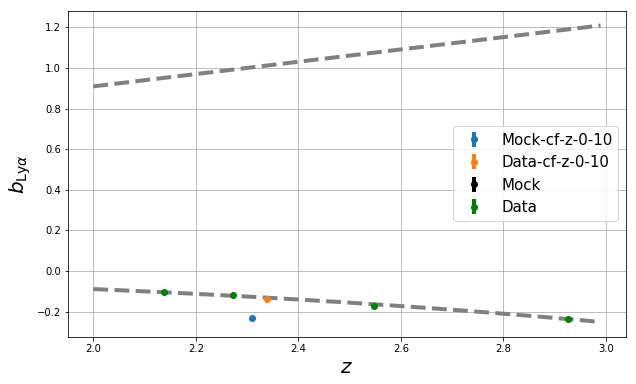

In [43]:
for name,vals in toPlot.items():
    if not 'FIT_RES' in vals.keys(): continue
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst ])
    try:
        biaseta = sp.array([ el['bias_eta_LYA'][0] for el in lst ])
    except:
        biaseta = sp.array([ el['bias_LYA'][0] for el in lst ])
    beta = sp.array([ el['beta_LYA'][0] for el in lst ])
    f = sp.array([ el['growth_rate'][0] for el in lst ])
    yyy = biaseta*f/beta
    err = sp.zeros(yyy.size)
    if 'Mock' in name and '0-10' not in name:
        continue
    elif 'Data' in name and '0-10' not in name:
        continue
    else:
        plt.errorbar(xxx,yyy,yerr=err,fmt='o',label=name)
    print(name,xxx,yyy)


### (Mock) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Data' in name) and (not '0-10' in name) and ('FIT_RES' in vals.keys()) ]
xxx = sp.array([ el['ZEFF'] for el in cor ])
biaseta = sp.array([ el['bias_eta_LYA'][0] for el in cor ])
beta = sp.array([ el['beta_LYA'][0] for el in cor ])
f = sp.array([ el['growth_rate'][0] for el in cor ])
yyy = biaseta*f/beta
err = sp.zeros(yyy.size)
plt.errorbar(xxx,yyy,yerr=err,fmt='o',color='black',label='Mock')
def chi2(a0,a1):
    r = sp.sum( (yyy-alpha(xxx,a0,a1))**2 )
    return r
m = Minuit(chi2, a0=1.,error_a0=1., a1=1.,error_a1=1.,print_level=-1, errordef=1.)
m.migrad()
m.hesse()
for p in m.values.keys():
    print(p, '=', m.values[p], '+/-', m.errors[p])
xxx = sp.arange(2.0, 3., 0.01)
plt.plot(xxx,alpha(xxx,m.values['a0'],m.values['a1']),'--',color='grey')

### (Data) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Mock' in name) and (not '0-10' in name) ]
xxx = sp.array([ el['ZEFF'] for el in cor ])
try:
    biaseta = sp.array([ el['bias_LYA'][0] for el in cor ])
except:
    biaseta = sp.array([ el['bias_eta_LYA'][0] for el in cor ])
beta = sp.array([ el['beta_LYA'][0] for el in cor ])
f = sp.array([ el['growth_rate'][0] for el in cor ])
yyy = biaseta*f/beta
err = sp.zeros(yyy.size)
print(xxx,yyy,err)
plt.errorbar(xxx,yyy,yerr=err,fmt='o',color='green',label='Data')
def chi2(a0,a1):
    r = sp.sum( (yyy-alpha(xxx,a0,a1))**2 )
    return r
m = Minuit(chi2, a0=1.,error_a0=1., a1=1.,error_a1=1.,print_level=-1, errordef=1.)
m.migrad()
m.hesse()
for p in m.values.keys():
    print(p, '=', m.values[p], '+/-', m.errors[p])
xxx = sp.arange(2.0, 3., 0.01)
plt.plot(xxx,alpha(xxx,m.values['a0'],m.values['a1']),'--',color='grey')

plt.xlabel(r'$z$')
plt.ylabel(r'$b_{\mathrm{Ly}\alpha}$')
plt.legend(fontsize=15)
plt.grid()
plt.show()

### The RSD parameter of the QSO

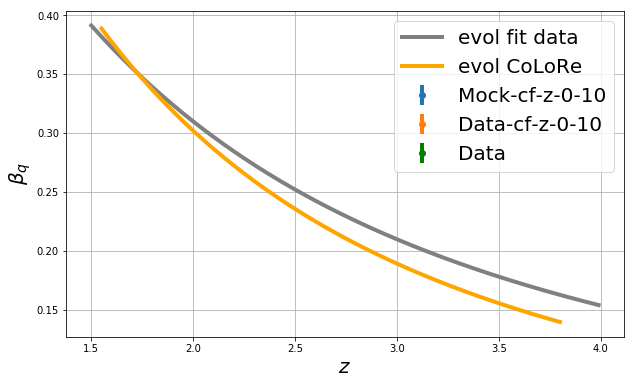

In [44]:
omega_M_0 = 0.315
z = sp.arange(1.5,4.,0.01)
f = growthRateStructure(z, omega_M_0)
bias = bias_vs_z_std(z, zref=0.37, alpha=1.44)
beta = f/bias
plt.plot(z,beta,linewidth=4,label='evol fit data',color='grey')

biasCoLoRe = sp.loadtxt(os.path.expandvars(mock['input_bias_QSO_evol']))
betaCoLoRe = growthRateStructure(biasCoLoRe[:,0], omega_M_0)/biasCoLoRe[:,1]
w = biasCoLoRe[:,0]>1.5
plt.plot(biasCoLoRe[:,0][w],betaCoLoRe[w],linewidth=4,label='evol CoLoRe',color='orange')

for name,vals in toPlot.items():
    if not 'FIT_RES' in vals.keys(): continue
    lst = [ vals['FIT_RES'] ]
    xxx = sp.array([ el['ZEFF'] for el in lst if ('beta_QSO' in el.keys())])
    yyy = sp.array([ el['beta_QSO'][0] for el in lst if ('beta_QSO' in el.keys()) ])
    zzz = sp.array([ el['beta_QSO'][1] for el in lst if ('beta_QSO' in el.keys()) ])
    if 'Mock' in name and '0-10' not in name:
        continue
    elif 'Data' in name and '0-10' not in name:
        continue
    else:
        plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)

### (Mock) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Data' in name)
       and (not '0-10' in name) and ('FIT_RES' in vals.keys())]
xxx = sp.array([ el['ZEFF'] for el in cor if ('beta_QSO' in el.keys()) ])
yyy = sp.array([ el['beta_QSO'][0] for el in cor if ('beta_QSO' in el.keys()) ])
err = sp.array([ el['beta_QSO'][1] for el in cor if ('beta_QSO' in el.keys()) ])
#plt.errorbar(xxx,yyy,err,fmt='o',color='black',label='Mock')

### (Data) Fit the evolution
cor = [vals['FIT_RES'] for name,vals in toPlot.items() if (not 'Mock' in name) and (not '0-10' in name) and ('FIT_RES' in vals.keys()) ]
xxx = sp.array([ el['ZEFF'] for el in cor if ('beta_QSO' in el.keys()) ])
yyy = sp.array([ el['beta_QSO'][0] for el in cor if ('beta_QSO' in el.keys()) ])
err = sp.array([ el['beta_QSO'][1] for el in cor if ('beta_QSO' in el.keys()) ])
plt.errorbar(xxx,yyy,err,fmt='o',color='green',label='Data')

plt.xlabel(r'$z$')
plt.ylabel(r'$\beta_{q}$')
plt.legend()
plt.grid()
plt.show()

### Other parameters

No handles with labels found to put in legend.


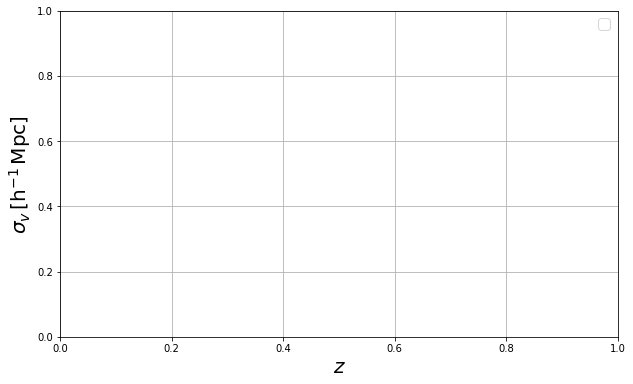

No handles with labels found to put in legend.


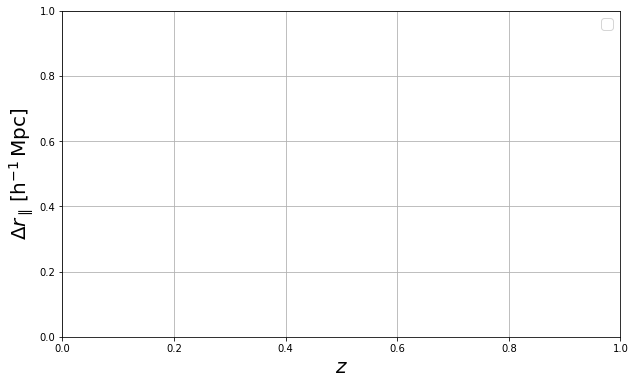

In [45]:
z = sp.arange(1.5,4.,0.01)
latexname = {'sigma_velo_lorentz_QSO':'\sigma_{v}\,[\mathrm{h^{-1}\,Mpc}]', 'drp_QSO':'\Delta r_{\parallel}\,[\mathrm{h^{-1}\,Mpc}]'}
for p in latexname.keys():
    iblack = True
    iGreen = True
    for name,vals in toPlot.items():
        if 'FIT_RES' not in vals.keys(): continue
        if (p not in vals['FIT_RES']) and (p.replace('_QSO','') not in vals['FIT_RES']): continue
        lst = [ vals['FIT_RES']  ]
        xxx = sp.array([ el['ZEFF'] for el in lst ])
        try:
            yyy = sp.array([ el[p][0] for el in lst ])
            zzz = sp.array([ el[p][1] for el in lst ])
        except:
            yyy = sp.array([ el[p.replace('_QSO','')][0] for el in lst ])
            zzz = sp.array([ el[p.replace('_QSO','')][1] for el in lst ])
        if 'Mock' in name and '0-10' not in name:
            if iblack:
                label = name
                iblack = False
            else:
                label = None
            plt.errorbar(xxx,yyy,zzz,fmt='o',color='black',label=label)
        elif 'Data' in name and '0-10' not in name:
            if iGreen:
                label = name
                iGreen = False
            else:
                label = None
            plt.errorbar(xxx,yyy,zzz,fmt='o',color='green',label=label)
        else:
            print(name, xxx, yyy, zzz)
            plt.errorbar(xxx,yyy,zzz,fmt='o',label=name)
    plt.xlabel(r'$z$')
    plt.ylabel(r'$'+latexname[p]+'$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()